# Imports

In [2]:
import sys
sys.path.append('..')

In [3]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import time

import alignment.alignment_utils as utils

%matplotlib inline

# Data Loading

### Real data

In [4]:
DATA_PATH = '../data/'
# data_filename = DATA_PATH + 'pt_decoding_data_S62.pkl'
data_filename = DATA_PATH + 'pt_decoding_data_S62_zscore.pkl'

In [5]:
all_pt_dict = utils.load_pkl(data_filename)
pt_names = list(all_pt_dict.keys())

In [6]:
print(pt_names)
print(all_pt_dict[pt_names[0]].keys())
print([all_pt_dict[pt]['X1'].shape for pt in pt_names])

['S14', 'S26', 'S23', 'S33', 'S22', 'S39', 'S58', 'S62']
dict_keys(['ID', 'X1', 'X1_map', 'y1', 'X2', 'X2_map', 'y2', 'X3', 'X3_map', 'y3', 'y_full_phon', 'X_collapsed', 'y_phon_collapsed', 'y_artic_collapsed', 'pre_pts'])
[(144, 200, 111), (148, 200, 111), (151, 200, 63), (46, 200, 149), (151, 200, 74), (137, 200, 144), (141, 200, 171), (178, 200, 201)]


In [7]:
all_pt_chan_data = {}
for pt in pt_names:
    temp = {}
    temp['map'] = sio.loadmat(DATA_PATH + f'{pt}/{pt}_channelMap.mat'.format(pt))['chanMap']
    # if pt == 'S58':
    #     temp['sig'] = sio.loadmat(DATA_PATH + f'{pt}/{pt}_sigChannel.mat'.format(pt))['sigChannel'] - 2 # this is so weird
    # else:
    temp['sig'] = sio.loadmat(DATA_PATH + f'{pt}/{pt}_sigChannel.mat'.format(pt))['sigChannel'] - 1
    all_pt_chan_data[pt] = temp

### Surrogate TME Data

In [8]:
# surr_types = ['T', 'N', 'C', 'TN', 'TC', 'NC', 'TNC']
# surr_types = ['N', 'C', 'NC']  # no T
# surr_types = ['T', 'C', 'TC']  # no N
# surr_types = ['T', 'N', 'TN'] # no C
surr_types = ['TNC']
# surr_types = ['TNC', 'T', 'TN']
surr_suffix = ''
# surr_suffix = '_zscore'


all_pt_surr_dict = {}
# for pt in pt_names:
#     all_surr_dict = {}
#     for surr in surr_types:
#         surr_data = sio.loadmat(f'../data/{pt}/TME/{pt}_TME_{surr}{surr_suffix}.mat')['surrTensor']
#         all_surr_dict[surr] = surr_data
#     all_pt_surr_dict[pt] = all_surr_dict


# print(all_pt_surr_dict.keys())
# print(all_pt_surr_dict['S14'].keys())
# print([all_pt_surr_dict[pt][surr].shape for pt in pt_names])

## Phoneme label processing functions

In [9]:
phon_labels = np.array(['a', 'ae', 'i', 'u', 'b', 'p', 'v', 'g', 'k'])
artic_labels = np.array(['low', 'high', 'labial', 'dorsal'])
phon_to_artic_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4}

In [10]:
def phon_to_artic(phon_idx, phon_to_artic_conv):
    return phon_to_artic_conv[phon_idx]

def phon_to_artic_seq(phon_seq, phon_to_artic_conv):
    flat_seq = phon_seq.flatten()
    artic_conv = np.array([phon_to_artic(phon_idx, phon_to_artic_conv) for phon_idx in flat_seq])
    return np.reshape(artic_conv, phon_seq.shape)

def phon2artic(phon):
    return artic_labels[phon_to_artic_dict[int(phon)] - 1]

def phon2artic_seq(phon_seq):
    return '_'.join([phon2artic(phon) for phon in phon_seq])

def labels2cv_seq(labels):
    labels_str = []
    for lab in labels:
        labels_str.append(labels2cv(lab))
    return np.array(labels_str)

def labels2cv(str):
    middle_val = str[1]
    if int(middle_val) < 5:
        return 'CVC'
    else:
        return 'VCV'

def articic_nums2seq(artic_num_seqs):
    return np.array([artic_labels[artic_num-1] for artic_num in artic_num_seqs])

## Data Processing

In [11]:
p_ind = 1

all_pt_traces = {}
all_pt_surr_traces = {}
all_pt_phon_labels = {}
all_pt_phon_seqs = {}
all_pt_phon_seqs_str = {}
all_pt_artic_labels = {}
all_pt_artic_seqs = {}
all_pt_artic_seqs_str = {}
all_pt_cv_labels = {}
for pt in pt_names:
    pt_trace = all_pt_dict[pt][f'X{p_ind}']  ### Real data: (trials, time, channels)

    # surr_type_traces = {}
    # for surr in surr_types:
    #     surr_type_traces[surr] = np.transpose(all_pt_surr_dict[pt][surr], [2,0,1])  ### Surrogate data: (time, channels, trials) -> (trials, time, channels)

    pt_phon_labels = all_pt_dict[pt][f'y{p_ind}']
    pt_phon_seqs = all_pt_dict[pt]['y_full_phon']
    pt_phon_seqs_str = utils.label_seq2str(pt_phon_seqs)
    pt_artic_labels = phon_to_artic_seq(pt_phon_labels, phon_to_artic_dict)
    pt_artic_seqs = phon_to_artic_seq(pt_phon_seqs, phon_to_artic_dict)
    pt_artic_seqs_str = utils.label_seq2str(pt_artic_seqs)
    pt_cv_labels = labels2cv_seq(pt_phon_seqs)

    all_pt_traces[pt] = pt_trace
    # all_pt_surr_traces[pt] = surr_type_traces
    all_pt_phon_labels[pt] = pt_phon_labels
    all_pt_phon_seqs[pt] = pt_phon_seqs
    all_pt_phon_seqs_str[pt] = pt_phon_seqs_str
    all_pt_artic_labels[pt] = pt_artic_labels
    all_pt_artic_seqs[pt] = pt_artic_seqs
    all_pt_artic_seqs_str[pt] = pt_artic_seqs_str
    all_pt_cv_labels[pt] = pt_cv_labels

In [12]:
# [all_pt_surr_traces[pt][list(all_pt_surr_traces[pt].keys())[0]].shape for pt in pt_names]

In [13]:
# artic_seq_strs = articic_nums2seq(pt_artic_seqs)
# artic_seq_strs = np.array([[s[0:2] + '_' for s in labs] for labs in artic_seq_strs])
# artic_seq_strs = utils.label2str(artic_seq_strs)
# artic_seq_strs = np.array([s[0:-1] for s in artic_seq_strs])

In [14]:
t = np.linspace(-0.5, 0.5 - 1/pt_trace.shape[1], pt_trace.shape[1])

In [15]:
# all_pt_phon_seq_avg_traces = {}
# all_pt_artic_seq_avg_traces = {}
# all_pt_phon_avg_traces = {}
# all_pt_artic_avg_traces = {}
# all_pt_cv_avg_traces = {}

# for pt in pt_names:
#     pt_trace = all_pt_traces[pt]
#     pt_phon_seqs_str = all_pt_phon_seqs_str[pt]
#     pt_artic_seqs_str = all_pt_artic_seqs_str[pt]
#     pt_phon_labels = all_pt_phon_labels[pt]
#     pt_artic_labels = all_pt_artic_labels[pt]
#     pt_cv_labels = all_pt_cv_labels[pt]

#     phon_seq_avg_trace = utils.cnd_avg(pt_trace, pt_phon_seqs_str)
#     artic_seq_avg_trace = utils.cnd_avg(pt_trace, pt_artic_seqs_str)
#     phon_avg_trace = utils.cnd_avg(pt_trace, pt_phon_labels)
#     artic_avg_trace = utils.cnd_avg(pt_trace, pt_artic_labels)
#     cv_avg_trace = utils.cnd_avg(pt_trace, pt_cv_labels)

#     all_pt_phon_seq_avg_traces[pt] = phon_seq_avg_trace
#     all_pt_artic_seq_avg_traces[pt] = artic_seq_avg_trace
#     all_pt_phon_avg_traces[pt] = phon_avg_trace
#     all_pt_artic_avg_traces[pt] = artic_avg_trace
#     all_pt_cv_avg_traces[pt] = cv_avg_trace

# Data Visualization

### Plotting utils

In [16]:
from matplotlib.colors import LinearSegmentedColormap

parula_data = cm_data = [[0.2422, 0.1504, 0.6603],
[0.2444, 0.1534, 0.6728],
[0.2464, 0.1569, 0.6847],
[0.2484, 0.1607, 0.6961],
[0.2503, 0.1648, 0.7071],
[0.2522, 0.1689, 0.7179],
[0.254, 0.1732, 0.7286],
[0.2558, 0.1773, 0.7393],
[0.2576, 0.1814, 0.7501],
[0.2594, 0.1854, 0.761],
[0.2611, 0.1893, 0.7719],
[0.2628, 0.1932, 0.7828],
[0.2645, 0.1972, 0.7937],
[0.2661, 0.2011, 0.8043],
[0.2676, 0.2052, 0.8148],
[0.2691, 0.2094, 0.8249],
[0.2704, 0.2138, 0.8346],
[0.2717, 0.2184, 0.8439],
[0.2729, 0.2231, 0.8528],
[0.274, 0.228, 0.8612],
[0.2749, 0.233, 0.8692],
[0.2758, 0.2382, 0.8767],
[0.2766, 0.2435, 0.884],
[0.2774, 0.2489, 0.8908],
[0.2781, 0.2543, 0.8973],
[0.2788, 0.2598, 0.9035],
[0.2794, 0.2653, 0.9094],
[0.2798, 0.2708, 0.915],
[0.2802, 0.2764, 0.9204],
[0.2806, 0.2819, 0.9255],
[0.2809, 0.2875, 0.9305],
[0.2811, 0.293, 0.9352],
[0.2813, 0.2985, 0.9397],
[0.2814, 0.304, 0.9441],
[0.2814, 0.3095, 0.9483],
[0.2813, 0.315, 0.9524],
[0.2811, 0.3204, 0.9563],
[0.2809, 0.3259, 0.96],
[0.2807, 0.3313, 0.9636],
[0.2803, 0.3367, 0.967],
[0.2798, 0.3421, 0.9702],
[0.2791, 0.3475, 0.9733],
[0.2784, 0.3529, 0.9763],
[0.2776, 0.3583, 0.9791],
[0.2766, 0.3638, 0.9817],
[0.2754, 0.3693, 0.984],
[0.2741, 0.3748, 0.9862],
[0.2726, 0.3804, 0.9881],
[0.271, 0.386, 0.9898],
[0.2691, 0.3916, 0.9912],
[0.267, 0.3973, 0.9924],
[0.2647, 0.403, 0.9935],
[0.2621, 0.4088, 0.9946],
[0.2591, 0.4145, 0.9955],
[0.2556, 0.4203, 0.9965],
[0.2517, 0.4261, 0.9974],
[0.2473, 0.4319, 0.9983],
[0.2424, 0.4378, 0.9991],
[0.2369, 0.4437, 0.9996],
[0.2311, 0.4497, 0.9995],
[0.225, 0.4559, 0.9985],
[0.2189, 0.462, 0.9968],
[0.2128, 0.4682, 0.9948],
[0.2066, 0.4743, 0.9926],
[0.2006, 0.4803, 0.9906],
[0.195, 0.4861, 0.9887],
[0.1903, 0.4919, 0.9867],
[0.1869, 0.4975, 0.9844],
[0.1847, 0.503, 0.9819],
[0.1831, 0.5084, 0.9793],
[0.1818, 0.5138, 0.9766],
[0.1806, 0.5191, 0.9738],
[0.1795, 0.5244, 0.9709],
[0.1785, 0.5296, 0.9677],
[0.1778, 0.5349, 0.9641],
[0.1773, 0.5401, 0.9602],
[0.1768, 0.5452, 0.956],
[0.1764, 0.5504, 0.9516],
[0.1755, 0.5554, 0.9473],
[0.174, 0.5605, 0.9432],
[0.1716, 0.5655, 0.9393],
[0.1686, 0.5705, 0.9357],
[0.1649, 0.5755, 0.9323],
[0.161, 0.5805, 0.9289],
[0.1573, 0.5854, 0.9254],
[0.154, 0.5902, 0.9218],
[0.1513, 0.595, 0.9182],
[0.1492, 0.5997, 0.9147],
[0.1475, 0.6043, 0.9113],
[0.1461, 0.6089, 0.908],
[0.1446, 0.6135, 0.905],
[0.1429, 0.618, 0.9022],
[0.1408, 0.6226, 0.8998],
[0.1383, 0.6272, 0.8975],
[0.1354, 0.6317, 0.8953],
[0.1321, 0.6363, 0.8932],
[0.1288, 0.6408, 0.891],
[0.1253, 0.6453, 0.8887],
[0.1219, 0.6497, 0.8862],
[0.1185, 0.6541, 0.8834],
[0.1152, 0.6584, 0.8804],
[0.1119, 0.6627, 0.877],
[0.1085, 0.6669, 0.8734],
[0.1048, 0.671, 0.8695],
[0.1009, 0.675, 0.8653],
[0.0964, 0.6789, 0.8609],
[0.0914, 0.6828, 0.8562],
[0.0855, 0.6865, 0.8513],
[0.0789, 0.6902, 0.8462],
[0.0713, 0.6938, 0.8409],
[0.0628, 0.6972, 0.8355],
[0.0535, 0.7006, 0.8299],
[0.0433, 0.7039, 0.8242],
[0.0328, 0.7071, 0.8183],
[0.0234, 0.7103, 0.8124],
[0.0155, 0.7133, 0.8064],
[0.0091, 0.7163, 0.8003],
[0.0046, 0.7192, 0.7941],
[0.0019, 0.722, 0.7878],
[0.0009, 0.7248, 0.7815],
[0.0018, 0.7275, 0.7752],
[0.0046, 0.7301, 0.7688],
[0.0094, 0.7327, 0.7623],
[0.0162, 0.7352, 0.7558],
[0.0253, 0.7376, 0.7492],
[0.0369, 0.74, 0.7426],
[0.0504, 0.7423, 0.7359],
[0.0638, 0.7446, 0.7292],
[0.077, 0.7468, 0.7224],
[0.0899, 0.7489, 0.7156],
[0.1023, 0.751, 0.7088],
[0.1141, 0.7531, 0.7019],
[0.1252, 0.7552, 0.695],
[0.1354, 0.7572, 0.6881],
[0.1448, 0.7593, 0.6812],
[0.1532, 0.7614, 0.6741],
[0.1609, 0.7635, 0.6671],
[0.1678, 0.7656, 0.6599],
[0.1741, 0.7678, 0.6527],
[0.1799, 0.7699, 0.6454],
[0.1853, 0.7721, 0.6379],
[0.1905, 0.7743, 0.6303],
[0.1954, 0.7765, 0.6225],
[0.2003, 0.7787, 0.6146],
[0.2061, 0.7808, 0.6065],
[0.2118, 0.7828, 0.5983],
[0.2178, 0.7849, 0.5899],
[0.2244, 0.7869, 0.5813],
[0.2318, 0.7887, 0.5725],
[0.2401, 0.7905, 0.5636],
[0.2491, 0.7922, 0.5546],
[0.2589, 0.7937, 0.5454],
[0.2695, 0.7951, 0.536],
[0.2809, 0.7964, 0.5266],
[0.2929, 0.7975, 0.517],
[0.3052, 0.7985, 0.5074],
[0.3176, 0.7994, 0.4975],
[0.3301, 0.8002, 0.4876],
[0.3424, 0.8009, 0.4774],
[0.3548, 0.8016, 0.4669],
[0.3671, 0.8021, 0.4563],
[0.3795, 0.8026, 0.4454],
[0.3921, 0.8029, 0.4344],
[0.405, 0.8031, 0.4233],
[0.4184, 0.803, 0.4122],
[0.4322, 0.8028, 0.4013],
[0.4463, 0.8024, 0.3904],
[0.4608, 0.8018, 0.3797],
[0.4753, 0.8011, 0.3691],
[0.4899, 0.8002, 0.3586],
[0.5044, 0.7993, 0.348],
[0.5187, 0.7982, 0.3374],
[0.5329, 0.797, 0.3267],
[0.547, 0.7957, 0.3159],
[0.5609, 0.7943, 0.305],
[0.5748, 0.7929, 0.2941],
[0.5886, 0.7913, 0.2833],
[0.6024, 0.7896, 0.2726],
[0.6161, 0.7878, 0.2622],
[0.6297, 0.7859, 0.2521],
[0.6433, 0.7839, 0.2423],
[0.6567, 0.7818, 0.2329],
[0.6701, 0.7796, 0.2239],
[0.6833, 0.7773, 0.2155],
[0.6963, 0.775, 0.2075],
[0.7091, 0.7727, 0.1998],
[0.7218, 0.7703, 0.1924],
[0.7344, 0.7679, 0.1852],
[0.7468, 0.7654, 0.1782],
[0.759, 0.7629, 0.1717],
[0.771, 0.7604, 0.1658],
[0.7829, 0.7579, 0.1608],
[0.7945, 0.7554, 0.157],
[0.806, 0.7529, 0.1546],
[0.8172, 0.7505, 0.1535],
[0.8281, 0.7481, 0.1536],
[0.8389, 0.7457, 0.1546],
[0.8495, 0.7435, 0.1564],
[0.86, 0.7413, 0.1587],
[0.8703, 0.7392, 0.1615],
[0.8804, 0.7372, 0.165],
[0.8903, 0.7353, 0.1695],
[0.9, 0.7336, 0.1749],
[0.9093, 0.7321, 0.1815],
[0.9184, 0.7308, 0.189],
[0.9272, 0.7298, 0.1973],
[0.9357, 0.729, 0.2061],
[0.944, 0.7285, 0.2151],
[0.9523, 0.7284, 0.2237],
[0.9606, 0.7285, 0.2312],
[0.9689, 0.7292, 0.2373],
[0.977, 0.7304, 0.2418],
[0.9842, 0.733, 0.2446],
[0.99, 0.7365, 0.2429],
[0.9946, 0.7407, 0.2394],
[0.9966, 0.7458, 0.2351],
[0.9971, 0.7513, 0.2309],
[0.9972, 0.7569, 0.2267],
[0.9971, 0.7626, 0.2224],
[0.9969, 0.7683, 0.2181],
[0.9966, 0.774, 0.2138],
[0.9962, 0.7798, 0.2095],
[0.9957, 0.7856, 0.2053],
[0.9949, 0.7915, 0.2012],
[0.9938, 0.7974, 0.1974],
[0.9923, 0.8034, 0.1939],
[0.9906, 0.8095, 0.1906],
[0.9885, 0.8156, 0.1875],
[0.9861, 0.8218, 0.1846],
[0.9835, 0.828, 0.1817],
[0.9807, 0.8342, 0.1787],
[0.9778, 0.8404, 0.1757],
[0.9748, 0.8467, 0.1726],
[0.972, 0.8529, 0.1695],
[0.9694, 0.8591, 0.1665],
[0.9671, 0.8654, 0.1636],
[0.9651, 0.8716, 0.1608],
[0.9634, 0.8778, 0.1582],
[0.9619, 0.884, 0.1557],
[0.9608, 0.8902, 0.1532],
[0.9601, 0.8963, 0.1507],
[0.9596, 0.9023, 0.148],
[0.9595, 0.9084, 0.145],
[0.9597, 0.9143, 0.1418],
[0.9601, 0.9203, 0.1382],
[0.9608, 0.9262, 0.1344],
[0.9618, 0.932, 0.1304],
[0.9629, 0.9379, 0.1261],
[0.9642, 0.9437, 0.1216],
[0.9657, 0.9494, 0.1168],
[0.9674, 0.9552, 0.1116],
[0.9692, 0.9609, 0.1061],
[0.9711, 0.9667, 0.1001],
[0.973, 0.9724, 0.0938],
[0.9749, 0.9782, 0.0872],
[0.9769, 0.9839, 0.0805]]

parula_map = LinearSegmentedColormap.from_list('parula', parula_data)

In [17]:
def line(error_y_mode=None, **kwargs):
    """Extension of `plotly.express.line` to use error bands.
    
    From https://stackoverflow.com/questions/69587547/continuous-error-band-with-plotly-express-in-python, user171780"""
    ERROR_MODES = {'bar','band','bars','bands',None}
    if error_y_mode not in ERROR_MODES:
        raise ValueError(f"'error_y_mode' must be one of {ERROR_MODES}, received {repr(error_y_mode)}.")
    if error_y_mode in {'bar','bars',None}:
        fig = px.line(**kwargs)
    elif error_y_mode in {'band','bands'}:
        if 'error_y' not in kwargs:
            raise ValueError(f"If you provide argument 'error_y_mode' you must also provide 'error_y'.")
        figure_with_error_bars = px.line(**kwargs)
        fig = px.line(**{arg: val for arg,val in kwargs.items() if arg != 'error_y'})
        for data in figure_with_error_bars.data:
            x = list(data['x'])
            y_upper = list(data['y'] + data['error_y']['array'])
            y_lower = list(data['y'] - data['error_y']['array'] if data['error_y']['arrayminus'] is None else data['y'] - data['error_y']['arrayminus'])
            color = f"rgba({tuple(int(data['line']['color'].lstrip('#')[i:i+2], 16) for i in (0, 2, 4))},.3)".replace('((','(').replace('),',',').replace(' ','')
            fig.add_trace(
                go.Scatter(
                    x = x+x[::-1],
                    y = y_upper+y_lower[::-1],
                    fill = 'toself',
                    fillcolor = color,
                    line = dict(
                        color = 'rgba(255,255,255,0)'
                    ),
                    hoverinfo = "skip",
                    showlegend = False,
                    legendgroup = data['legendgroup'],
                    xaxis = data['xaxis'],
                    yaxis = data['yaxis'],
                )
            )
        # Reorder data as said here: https://stackoverflow.com/a/66854398/8849755
        reordered_data = []
        for i in range(int(len(fig.data)/2)):
            reordered_data.append(fig.data[i+int(len(fig.data)/2)])
            reordered_data.append(fig.data[i])
        fig.data = tuple(reordered_data)
    return fig

## CCA Alignment

In [27]:
from alignment.AlignCCA import AlignCCA
from decoders.cross_pt_decoders import crossPtDecoder_sepAlign

### TME Correlation

In [27]:
# pca_comp = 30
pca_comp = 0.9
cca_comp = 10
t_win = np.array([-0.25, 0.25])
t_inds = np.where((t >= t_win[0]) & (t < t_win[1]))[0]

pairwise_corrs = []
for tar_pt in pt_names:
    other_pts = [pt for pt in pt_names if pt != tar_pt]
# for tar_pt in ['S14', 'S26', 'S33']:
#     other_pts = [pt for pt in ['S14', 'S26', 'S33'] if pt != tar_pt]

    tar_pt_data = (all_pt_traces[tar_pt][:, t_inds, :], all_pt_phon_labels[tar_pt], all_pt_phon_seqs_str[tar_pt])
    cross_pt_data = [(all_pt_traces[pt][:, t_inds, :], all_pt_phon_labels[pt], all_pt_phon_seqs_str[pt]) for pt in other_pts]

    cca_wrapper = crossPtDecoder_sepAlign(cross_pt_data, None, AlignCCA, n_comp=pca_comp)
    pooled_traces, pooled_labels = cca_wrapper.preprocess_train(tar_pt_data[0], tar_pt_data[1], y_align=tar_pt_data[2])  ## align by full phoneme sequence
    aligners = cca_wrapper.algns
    CCs = [a.canon_corrs[:cca_comp] for a in aligners]
    
    for pt, corrs in zip(other_pts, CCs):
        data = {'Data': 'Real', 'Patient 1': tar_pt, 'Patient 2': pt}
        data_corr = {}
        for i, c in enumerate(corrs):
            data_corr[f'CC {i+1}'] = c
        data = dict(data, **data_corr)

        pairwise_corrs.append(data)
pairwise_corrs = pd.DataFrame(pairwise_corrs)
    
pairwise_corrs_surr = []
for tar_pt in pt_names:
    other_pts = [pt for pt in pt_names if pt != tar_pt]
# for tar_pt in ['S14', 'S26', 'S33']:
#     other_pts = [pt for pt in ['S14', 'S26', 'S33'] if pt != tar_pt]

    for surr in surr_types:
        tar_pt_data = (all_pt_surr_traces[tar_pt][surr][:, t_inds, :], all_pt_phon_labels[tar_pt], all_pt_phon_seqs_str[tar_pt])
        # tar_pt_data = (all_pt_traces[tar_pt][:, t_inds, :], all_pt_phon_labels[tar_pt], all_pt_phon_seqs_str[tar_pt])  # only using surrogate data for aligned patients
        cross_pt_data = [(all_pt_surr_traces[pt][surr][:, t_inds, :], all_pt_phon_labels[pt], all_pt_phon_seqs_str[pt]) for pt in pt_names if pt != tar_pt]
        # cross_pt_data = [(all_pt_traces[pt][:, t_inds, :], all_pt_phon_labels[pt], all_pt_phon_seqs_str[pt]) for pt in pt_names if pt != tar_pt]

        cca_wrapper = crossPtDecoder_sepAlign(cross_pt_data, None, AlignCCA, n_comp=pca_comp)  # using decoder class without decoder to handle data preprocessing
        _, _ = cca_wrapper.preprocess_train(tar_pt_data[0], tar_pt_data[1], y_align=tar_pt_data[2])  ## align by full phoneme sequence
        aligners = cca_wrapper.algns
        CCs = [a.canon_corrs[:cca_comp] for a in aligners]

        for pt, corrs in zip(other_pts, CCs):
            data = {'Data': surr + ' (TME)', 'Patient 1': tar_pt, 'Patient 2': pt}
            data_corr = {}
            for i, c in enumerate(corrs):
                data_corr[f'CC {i+1}'] = c
            data = dict(data, **data_corr)

            pairwise_corrs_surr.append(data)
pairwise_corrs_surr = pd.DataFrame(pairwise_corrs_surr)

In [28]:
cc_df_wide = pd.concat([pairwise_corrs, pairwise_corrs_surr], ignore_index=True)
cc_df_long = cc_df_wide.melt(id_vars=['Data', 'Patient 1', 'Patient 2'], var_name='Latent Component', value_name='Canonical Correlation')
cc_df_long['Latent Component'] = cc_df_long['Latent Component'].str.replace('CC ', '').astype(int)
# cc_df_long = cc_df_long.sort_values(by=['Data', 'Patient 1', 'Patient 2', 'Latent Component'])

In [29]:
cc_df_long
# cc_df_long[cc_df_long['Data'] == 'Real']
# cc_df_long[cc_df_long['Data'] == 'TC (TME)']

,Data,Patient 1,Patient 2,Latent Component,Canonical Correlation
0,Real,S14,S26,1,0.710576
1,Real,S14,S23,1,0.650906
2,Real,S14,S33,1,0.714256
3,Real,S14,S22,1,0.570634
4,Real,S26,S14,1,0.710576
...,...,...,...,...,...
395,TNC (TME),S33,S22,10,NaN
396,TNC (TME),S22,S14,10,NaN
397,TNC (TME),S22,S26,10,NaN
398,TNC (TME),S22,S23,10,NaN


#### Visualization

In [30]:
from matplotlib.ticker import MultipleLocator
import scipy.stats as stats

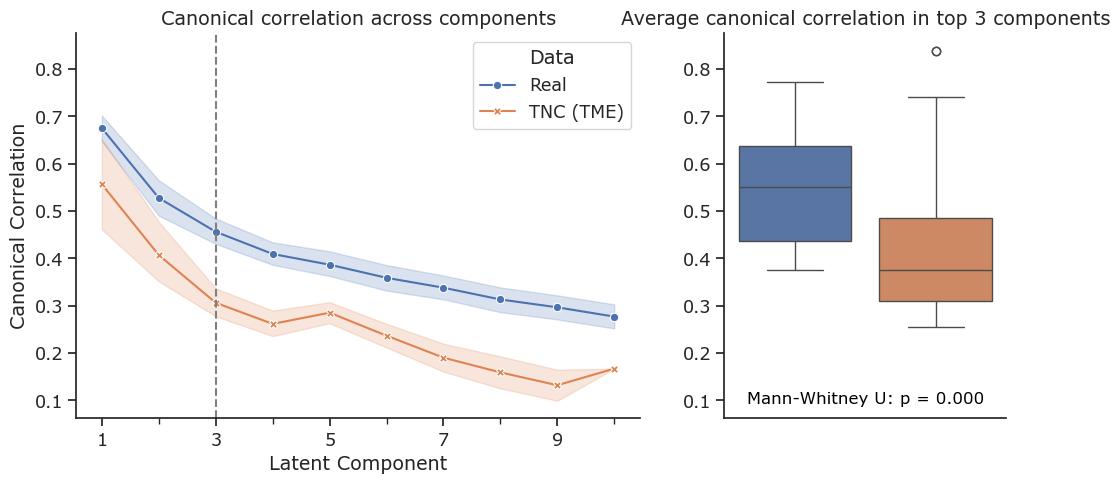

MannwhitneyuResult(statistic=1684.0, pvalue=2.4704116718772917e-06)


In [31]:
hist_comps = 3

sns.set_theme(context='notebook', font='Verdana', font_scale=1.15, style='ticks')
f, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True, width_ratios=[1, 0.5])
# f, axs = plt.subplots(1, 2, figsize=(15,5), sharey=True, width_ratios=[1, 1.25])

sns.lineplot(data=cc_df_long, x='Latent Component', y='Canonical Correlation', hue='Data', style='Data', markers=True, dashes=False, ax=axs[0])
axs[0].axvline(x=hist_comps, color='grey', linestyle='dashed')
axs[0].set_xticks(np.arange(1, 10, 2))
axs[0].xaxis.set_minor_locator(MultipleLocator(2))
axs[0].set_title('Canonical correlation across components')


# sns.histplot(data=cc_df_long[cc_df_long['Neural Mode'] <= 4], y='Canonical Correlation', hue='Data', binwidth=0.15, ax=axs[1])
# sns.histplot(data=cc_df_long[cc_df_long['Component'] <= hist_comps], y='Canonical Correlation', hue='Data', ax=axs[1])
# sns.histplot(data=cc_df_long[(cc_df_long['Latent Component'] <= hist_comps)].groupby(['Data', 'Patient 1', 'Patient 2']).mean().loc[cc_df_long['Data'].unique()], y='Canonical Correlation', hue='Data', ax=axs[1], element='step')
sns.boxplot(data=cc_df_long[cc_df_long['Latent Component'] <= hist_comps], x='Data', y='Canonical Correlation', hue='Data', ax=axs[1])
axs[1].set_title(f'Average canonical correlation in top {hist_comps} components')
axs[1].yaxis.set_tick_params(labelbottom=True)
axs[1].legend([],[], frameon=False)
axs[1].set_xticklabels([])
axs[1].set_xlabel('')
axs[1].set_xticks([])

mwu_res = stats.mannwhitneyu(cc_df_long[(cc_df_long['Data'] == 'Real') & (cc_df_long['Latent Component'] <= hist_comps)]['Canonical Correlation'],
                             cc_df_long[(cc_df_long['Data'] == 'TNC (TME)') & (cc_df_long['Latent Component'] <= hist_comps)]['Canonical Correlation'],
                             alternative='greater', nan_policy='omit')
# annotate p-value on box plot
axs[1].annotate(f'Mann-Whitney U: p = {mwu_res.pvalue:.3f}', xy=(0.5, 0.05), xycoords='axes fraction', ha='center', va='center', fontsize=12, color='black', backgroundcolor='white')

sns.despine()
plt.show()
print(mwu_res)

In [21]:
test_res = stats.mannwhitneyu(cc_df_long[(cc_df_long['Data'] == 'TN (TME)') & (cc_df_long['Latent Component'] <= hist_comps)]['Canonical Correlation'],
                             cc_df_long[(cc_df_long['Data'] == 'TNC (TME)') & (cc_df_long['Latent Component'] <= hist_comps)]['Canonical Correlation'],
                             alternative='greater', nan_policy='omit')
print(test_res)

ValueError: `x` and `y` must be of nonzero size.

In [ ]:
cc_df_long[(cc_df_long['Latent Component'] <= hist_comps)].groupby(['Data', 'Patient 1', 'Patient 2']).mean().loc[cc_df_long['Data'].unique()]

### TSNE with aligned data

In [35]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples

#### Pt-Specific

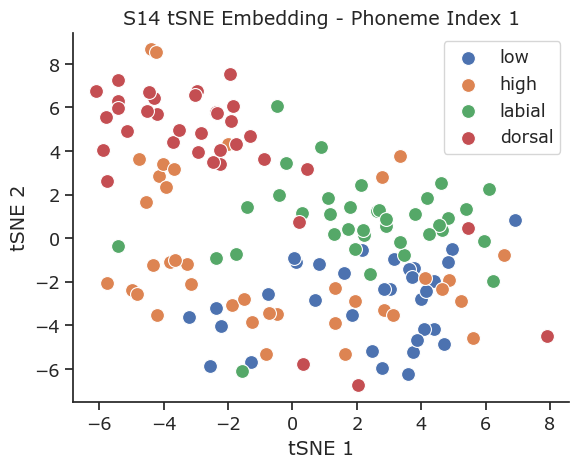

In [36]:
pt = 'S14'
curr_trace = all_pt_traces[pt]
curr_labels = all_pt_artic_labels[pt]
curr_label_names = artic_labels

t_pca_comp = 0.8
pt_time_pca = PCA(n_components=t_pca_comp).fit_transform(curr_trace.reshape(curr_trace.shape[0], -1))
pt_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(pt_time_pca)
# pt_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(curr_trace.reshape(curr_trace.shape[0], -1))

sns.set_theme(context='notebook', font='Verdana', font_scale=1.15, style='ticks')
plt.figure()
for lab in np.unique(curr_labels):
    sns.scatterplot(x=-pt_embed_time[np.where(curr_labels == lab)[0],1], y=-pt_embed_time[np.where(curr_labels == lab)[0],0], s=100)
    # plt.scatter([],[],label=curr_label_names[lab-1])
# sns.scatterplot(x=pt_embed_time[:,0], y=pt_embed_time[:,1], hue=curr_labels, palette='tab10', legend='full')
# plt.scatter(S14_embed_t0[:,0], S14_embed_t0[:,1], c=S14_artic_labels[:,0])
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.title(f'{pt} tSNE Embedding - Phoneme Index {p_ind}')
plt.legend(labels=curr_label_names)

sns.despine()
plt.show()

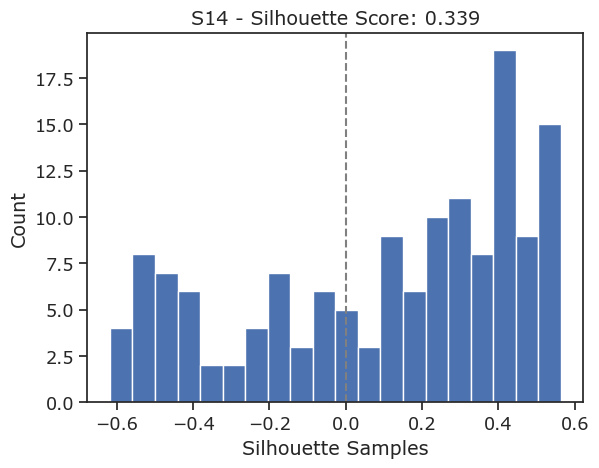

In [37]:
ps_sils = silhouette_samples(pt_embed_time, curr_labels)
ps_sil_score = np.mean(ps_sils[np.where(ps_sils > 0)])
plt.figure()
plt.hist(ps_sils, bins=20)
plt.axvline(0, color='grey', linestyle='dashed')
plt.xlabel('Silhouette Samples')
plt.ylabel('Count')
plt.title(f'{pt} - Silhouette Score: {ps_sil_score:.3f}')
plt.show()

In [175]:
n_iter = 50
ps_sil_scores = np.zeros(n_iter)
ps_sil_scores_shuf = np.zeros(n_iter)
for i in range(n_iter):

    pt_time_pca = PCA(n_components=t_pca_comp).fit_transform(curr_trace.reshape(curr_trace.shape[0], -1))
    pt_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(pt_time_pca)
    ps_sils = silhouette_samples(pt_embed_time, curr_labels)
    ps_sils_shuf = silhouette_samples(pt_embed_time, np.random.permutation(curr_labels))
    ps_score = np.mean(ps_sils[np.where(ps_sils > 0)])
    ps_score_shuf = np.mean(ps_sils_shuf[np.where(ps_sils_shuf > 0)])
    ps_sil_scores[i] = ps_score
    ps_sil_scores_shuf[i] = ps_score_shuf


In [177]:
sil_df_real_long = pd.DataFrame({'Silhouette Score': ps_sil_scores})
# sil_df_real_long = sil_df_real.melt(var_name='Data', value_name='Silhouette Score')
sil_df_shuf_long = pd.DataFrame({'Silhouette Score': ps_sil_scores_shuf})
# # sil_df_shuf_long = sil_df_shuf.melt(var_name='Data', value_name='Silhouette Score')
sil_df_real_long['Condition'] = 'Articulatory Features'
sil_df_shuf_long['Condition'] = 'Chance Distribution'
sil_df_long = pd.concat([sil_df_real_long, sil_df_shuf_long], ignore_index=True)
ps_sil_df_long = sil_df_real_long

In [178]:
ps_sil_df_long['Silhouette Score'].mean()

0.3133480778336525

In [62]:
fig = px.box(sil_df_long, color='Condition', y="Silhouette Score", points='all', width=600, height=500)
# fig.add_hline(y=1/9, line_dash='dash', line_color='grey', annotation_text='Chance', annotation_position='bottom right')
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='top',
        y=0.98,
        xanchor='left',
        x=0.02,
        title_text=''
    ),
    # showlegend=False,
    title_text=f'S1 Clustering Strength of Articulatory Featrures',
    title_x=0.5,
    font=dict(size=17, family='Arial')
)
fig.update_xaxes(
    title='',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    # tickvals=[0,1],
    # range=[-0.5, 3.5],
    # ticktext=['Patient-Specific', 'Shared Neural<br>Latent Space'],
)
fig.update_yaxes(
    title='Silhouette Score',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    range=[0, 0.42]
)
fig.show()

#### Unaligned

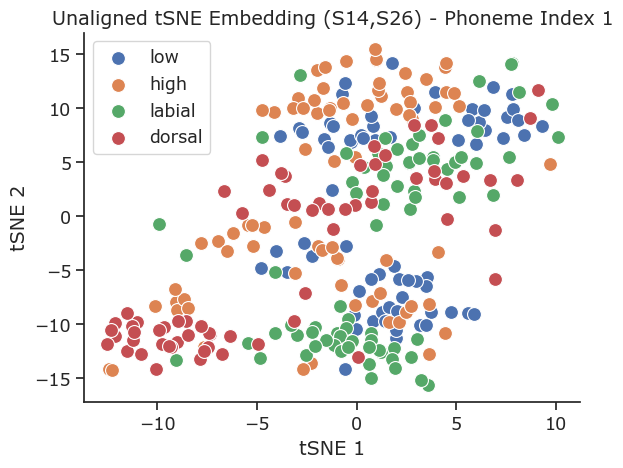

In [260]:
pts = ['S14', 'S26']

curr_unalgn = [PCA(n_components=0.9).fit_transform(all_pt_traces[pt].reshape(-1, all_pt_traces[pt].shape[-1])) for pt in pts]
min_dim = min(u.shape[-1] for u in curr_unalgn)
curr_unalgn = np.vstack([curr_unalgn[i][:,:min_dim].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1) for i,pt in enumerate(pts)])
curr_unalgn_labels = np.hstack([all_pt_artic_labels[pt] for pt in pts])

t_pca_comp = 0.8
unalgn_time_pca = PCA(n_components=t_pca_comp).fit_transform(curr_unalgn.reshape(curr_unalgn.shape[0], -1))
unalgn_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(unalgn_time_pca)

sns.set_theme(context='notebook', font='Verdana', font_scale=1.15, style='ticks')
plt.figure()
for lab in np.unique(curr_unalgn_labels):
    sns.scatterplot(x=-unalgn_embed_time[np.where(curr_unalgn_labels == lab)[0],1], y=-unalgn_embed_time[np.where(curr_unalgn_labels == lab)[0],0], s=100)
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.title(f'Unaligned tSNE Embedding ({",".join(pts)}) - Phoneme Index {p_ind}')
plt.legend(labels=curr_label_names)

sns.despine()
plt.show()

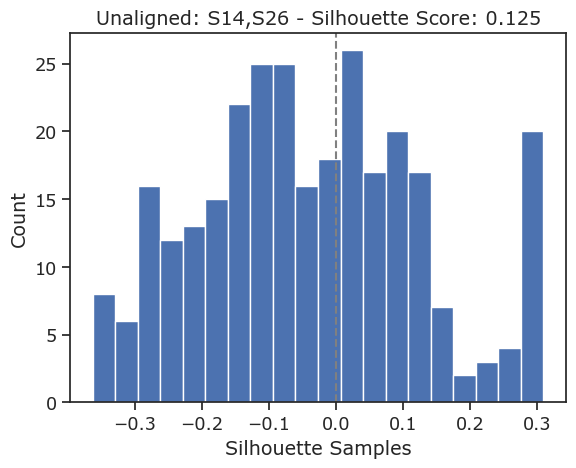

In [261]:
unalgn_sils = silhouette_samples(unalgn_embed_time, curr_unalgn_labels)
unalgn_sil_score = np.mean(unalgn_sils[np.where(unalgn_sils > 0)])
plt.figure()
plt.hist(unalgn_sils, bins=20)
plt.axvline(0, color='grey', linestyle='dashed')
plt.xlabel('Silhouette Samples')
plt.ylabel('Count')
plt.title(f'Unaligned: {",".join(pts)} - Silhouette Score: {unalgn_sil_score:.3f}')
plt.show()

#### CCA-Aligned

In [168]:
pts = ['S14', 'S26']
# aligner = AlignCCA(return_space='shared')
aligner = AlignCCA()
to_align = [PCA(n_components=0.9).fit_transform(all_pt_traces[pt].reshape(-1, all_pt_traces[pt].shape[-1])) for pt in pts]
to_align = [to_align[i].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1) for i, pt in enumerate(pts)]
# [x.shape for x in to_align]
to_align_seqs = [all_pt_phon_seqs[pt] for pt in pts]
aligner.fit(to_align[0], to_align[1], to_align_seqs[0], to_align_seqs[1])
# aligned_data = aligner.transform(to_align)
aligned_pt_data = aligner.transform(to_align[1])
aligned_data = [to_align[0], aligned_pt_data]

In [169]:
curr_algn = np.vstack(aligned_data)
curr_algn_labels = np.hstack([all_pt_artic_labels[pt] for pt in pts])

t_pca_comp = 0.8
algn_time_pca = PCA(n_components=t_pca_comp).fit_transform(curr_algn.reshape(curr_algn.shape[0], -1))
algn_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(algn_time_pca)
# algn_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(curr_algn.reshape(curr_algn.shape[0], -1))

algn_tsne_df = pd.DataFrame(algn_embed_time, columns=['tSNE 1', 'tSNE 2'])
algn_tsne_df['Patient'] = [pts[0]]*all_pt_traces[pts[0]].shape[0] + [pts[1]]*all_pt_traces[pts[1]].shape[0]
algn_tsne_df['Label'] = curr_algn_labels
algn_tsne_df['Label'] = algn_tsne_df['Label'].apply(lambda x: curr_label_names[x-1])

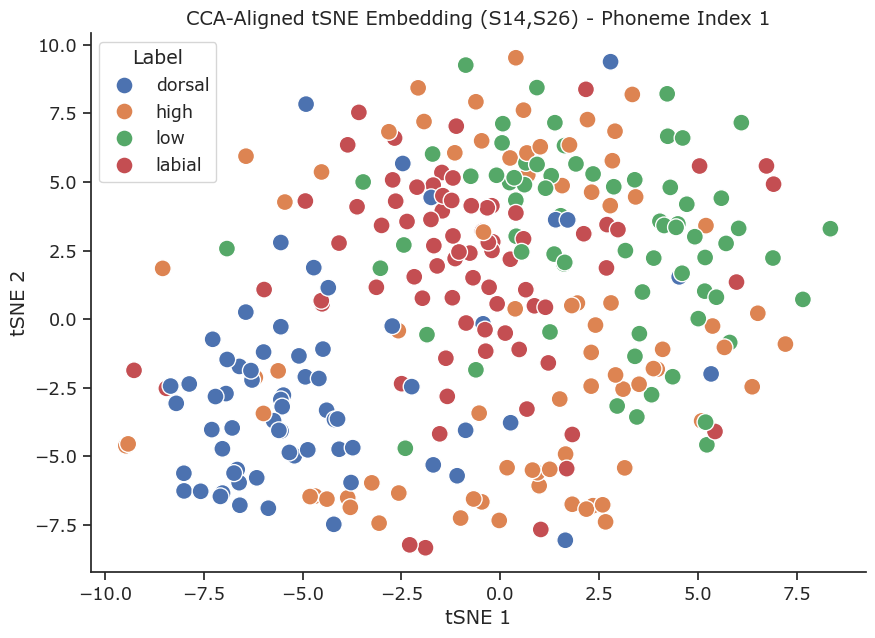

In [170]:


# sns.set_theme(context='notebook', font='Verdana', font_scale=1.15, style='ticks')
# plt.figure()
# for lab in np.unique(curr_algn_labels):
#     sns.scatterplot(x=-algn_embed_time[np.where(curr_algn_labels == lab)[0],1], y=-algn_embed_time[np.where(curr_algn_labels == lab)[0],0], s=100)
# plt.xlabel('tSNE 1')
# plt.ylabel('tSNE 2')
# plt.title(f'Aligned tSNE Embedding ({",".join(pts)}) - Phoneme Index {p_ind}')
# plt.legend(labels=curr_label_names)

# sns.despine()
# plt.show()


sns.set_theme(context='notebook', font='Verdana', font_scale=1.15, style='ticks')
f,ax = plt.subplots(1,1,figsize=(10,7))
# sns.scatterplot(data=algn_tsne_df, x='tSNE 1', y='tSNE 2', hue='Label', style='Patient', markers=True, s=150, ax=ax)
sns.scatterplot(data=algn_tsne_df, x='tSNE 1', y='tSNE 2', hue='Label', markers=True, s=150, ax=ax)
plt.title(f'CCA-Aligned tSNE Embedding ({",".join(pts)}) - Phoneme Index {p_ind}')
sns.despine()
plt.show()

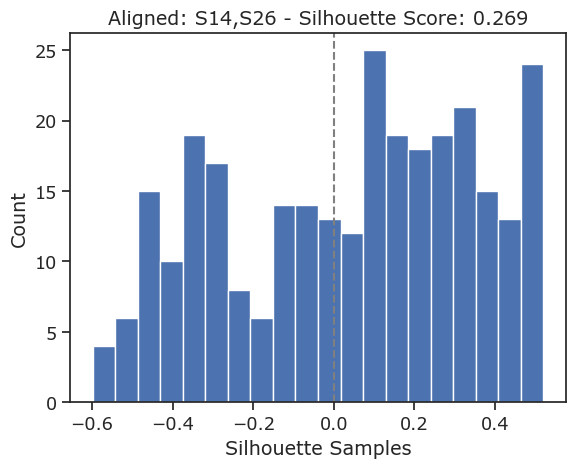

In [171]:
algn_sils = silhouette_samples(algn_embed_time, curr_algn_labels)
algn_sil_score = np.mean(algn_sils[np.where(algn_sils > 0)])
plt.figure()
plt.hist(algn_sils, bins=20)
plt.axvline(0, color='grey', linestyle='dashed')
plt.xlabel('Silhouette Samples')
plt.ylabel('Count')
plt.title(f'Aligned: {",".join(pts)} - Silhouette Score: {algn_sil_score:.3f}')
plt.show()

In [179]:
n_iter = 50
pts = ['S14', 'S26']
unalgn_sil_scores = np.zeros(n_iter)
unalgn_sil_scores_shuf = np.zeros(n_iter)
align_sil_scores = np.zeros(n_iter)
align_sil_scores_shuf = np.zeros(n_iter)
for i in range(n_iter):
    curr_unalgn = [PCA(n_components=0.9).fit_transform(all_pt_traces[pt].reshape(-1, all_pt_traces[pt].shape[-1])) for pt in pts]
    min_dim = min(u.shape[-1] for u in curr_unalgn)
    curr_unalgn = np.vstack([curr_unalgn[i][:,:min_dim].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1) for i,pt in enumerate(pts)])
    curr_unalgn_labels = np.hstack([all_pt_artic_labels[pt] for pt in pts])
    unalgn_time_pca = PCA(n_components=t_pca_comp).fit_transform(curr_unalgn.reshape(curr_unalgn.shape[0], -1))
    unalgn_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(unalgn_time_pca)
    unalgn_sils = silhouette_samples(unalgn_embed_time, curr_unalgn_labels)
    unalgn_sils_shuf = silhouette_samples(unalgn_embed_time, np.random.permutation(curr_unalgn_labels))
    unalgn_score = np.mean(unalgn_sils[np.where(unalgn_sils > 0)])
    unalgn_score_shuf = np.mean(unalgn_sils_shuf[np.where(unalgn_sils_shuf > 0)])
    unalgn_sil_scores[i] = unalgn_score
    unalgn_sil_scores_shuf[i] = unalgn_score_shuf
    
    aligner = AlignCCA()
    to_align = [PCA(n_components=0.9).fit_transform(all_pt_traces[pt].reshape(-1, all_pt_traces[pt].shape[-1])) for pt in pts]
    to_align = [to_align[i].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1) for i, pt in enumerate(pts)]
    # [x.shape for x in to_align]
    to_align_seqs = [all_pt_phon_seqs[pt] for pt in pts]
    aligner.fit(to_align[0], to_align[1], to_align_seqs[0], to_align_seqs[1])
    # aligned_data = aligner.transform(to_align)
    aligned_pt_data = aligner.transform(to_align[1])
    aligned_data = [to_align[0], aligned_pt_data]
    curr_algn = np.vstack(aligned_data)
    curr_algn_labels = np.hstack([all_pt_artic_labels[pt] for pt in pts])
    algn_time_pca = PCA(n_components=t_pca_comp).fit_transform(curr_algn.reshape(curr_algn.shape[0], -1))
    algn_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(algn_time_pca)
    algn_sils = silhouette_samples(algn_embed_time, curr_algn_labels)
    algn_sils_shuf = silhouette_samples(algn_embed_time, np.random.permutation(curr_algn_labels))
    algn_score = np.mean(algn_sils[np.where(algn_sils > 0)])
    algn_score_shuf = np.mean(algn_sils_shuf[np.where(algn_sils_shuf > 0)])
    align_sil_scores[i] = algn_score
    align_sil_scores_shuf[i] = algn_score_shuf


In [184]:
sil_df_real = pd.DataFrame({'Unaligned': unalgn_sil_scores, 'Aligned': align_sil_scores})
sil_df_real_long = sil_df_real.melt(var_name='Data', value_name='Silhouette Score')
sil_df_shuf = pd.DataFrame({'Unaligned': unalgn_sil_scores_shuf, 'Aligned': align_sil_scores_shuf})
sil_df_shuf_long = sil_df_shuf.melt(var_name='Data', value_name='Silhouette Score')
sil_df_real_long['Condition'] = 'Articulatory Features'
sil_df_shuf_long['Condition'] = 'Chance Distribution'
sil_df_long = pd.concat([sil_df_real_long, sil_df_shuf_long], ignore_index=True)


In [190]:
fig = px.box(sil_df_long, color='Condition', y="Silhouette Score", x='Data', points='all', width=700, height=500)
fig.add_hline(y=ps_sil_df_long['Silhouette Score'].mean(), line_dash='dash', line_color='grey', annotation_text='Patient-Specific', annotation_position='bottom left')
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='top',
        y=0.98,
        xanchor='left',
        x=0.02,
        title_text=''
    ),
    # showlegend=False,
    title_text=f'Clustering with CCA Alignment - {",".join(pts)}',
    title_x=0.5,
    font=dict(size=18, family='Arial')
)
fig.update_xaxes(
    title='',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    # tickvals=[0,1],
    # range=[-0.5, 3.5],
    # ticktext=['Patient-Specific', 'Shared Neural<br>Latent Space'],
)
fig.update_yaxes(
    title='Silhouette Score',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    range=[0, 0.38]
)
fig.show()

### CCA Correlations

In [71]:
all_pt_phon_seqs.keys()

dict_keys(['S14', 'S26', 'S23', 'S33', 'S22', 'S39', 'S58', 'S62'])

In [194]:
pts = pt_names
aligners = [AlignCCA() for _ in pts[1:]]
# aligner = AlignCCA(return_space='shared')
to_align = [PCA(n_components=0.9).fit_transform(all_pt_traces[pt].reshape(-1, all_pt_traces[pt].shape[-1])) for pt in pts]
to_align = [to_align[i].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1) for i, pt in enumerate(pts)]
# [x.shape for x in to_align]
aligned_data = [to_align[0]]
for i, pt in enumerate(pts[1:]):
    # print(pt)
    to_align_seqs = [all_pt_phon_seqs[pts[0]], all_pt_phon_seqs[pt]]
    aligners[i-1].fit(to_align[0], to_align[i+1], to_align_seqs[0], to_align_seqs[1])
    aligned_data.append(aligners[i-1].transform(to_align[i+1]))

# to_align_seqs = [all_pt_phon_seqs[pt] for pt in pts]
# aligner.fit(to_align[0], to_align[1], to_align_seqs[0], to_align_seqs[1])
# aligned_data = aligner.transform(to_align)

In [221]:
from scipy.stats import pearsonr

def pt_corr(target, to_corr, target_labels, to_corr_labels, n_comp=25):
    min_dim = np.min([target.shape[-1], to_corr.shape[-1], n_comp])
    cnd_avg_data = utils.extract_group_conditions([target, to_corr], [target_labels, to_corr_labels])
    n_cnds = cnd_avg_data[0].shape[0]
    cnd_r = np.zeros(n_cnds)
    for i in range(cnd_avg_data[0].shape[0]):
        target_avg = cnd_avg_data[0][i,:,:min_dim]
        to_corr_avg = cnd_avg_data[1][i,:,:min_dim]

        r_vals = np.zeros(min_dim)
        for j in range(min_dim):
            r_vals[j] = pearsonr(target_avg[:,j], to_corr_avg[:,j])[0]
        cnd_r[i] = np.mean(r_vals)
    return cnd_r

def pt_corr_multi(target, to_corr_list, target_labels, to_corr_labels_list, n_comp=25):
    cnd_r = []
    for i, to_corr in enumerate(to_corr_list):
        cnd_r.append(pt_corr(target, to_corr, target_labels, to_corr_labels_list[i], n_comp=n_comp))
    return cnd_r


In [222]:
n_comp_corr = 10
unalign_corrs = pt_corr_multi(to_align[0], to_align[1:], all_pt_artic_labels[pts[0]], [all_pt_artic_labels[pt] for pt in pts[1:]], n_comp=n_comp_corr)
align_corrs = pt_corr_multi(aligned_data[0], aligned_data[1:], all_pt_artic_labels[pts[0]], [all_pt_artic_labels[pt] for pt in pts[1:]], n_comp=n_comp_corr)

In [223]:
# combine unaligned and aligned correlations in dataframe for plotting
corr_df = pd.DataFrame()
corr_df_mean = pd.DataFrame()
for i, pt in enumerate(pts[1:]):
    curr_pt = f'S{i+2}'
    pt_unalign_corr = pd.DataFrame({'Correlation': unalign_corrs[i]})
    pt_unalign_corr['Condition'] = 'Unaligned'
    pt_unalign_corr['Patient'] = curr_pt
    pt_unalign_corr['Error'] = 0

    pt_align_corr = pd.DataFrame({'Correlation': align_corrs[i]})
    pt_align_corr['Condition'] = 'Aligned to S1'
    pt_align_corr['Patient'] = curr_pt
    pt_align_corr['Error'] = 0

    corr_df_mean = pd.concat([corr_df_mean, pd.DataFrame({'Correlation': [np.mean(unalign_corrs[i]), np.mean(align_corrs[i])], 'Condition': ['Unaligned', 'Aligned to S1'], 'Patient': [curr_pt, curr_pt]})], ignore_index=True)

    corr_df = pd.concat([corr_df, pt_unalign_corr, pt_align_corr], ignore_index=True) 

In [226]:
fig = px.line(corr_df_mean, x='Condition', y="Correlation", color='Patient', width=700, height=500, color_discrete_sequence=px.colors.qualitative.Plotly[1:])
fig.update_traces(mode='lines')
fig.add_traces(px.box(corr_df_mean, x='Condition', y="Correlation").data)
# fig = px.box(corr_df, x='Condition', y="Correlation", width=800, height=500)
# fig.add_traces(px.line(corr_df, x='Condition', y="Correlation", color='Patient', error_y='Error').data)
# fig.update_traces(mode='markers+lines')
# fig.add_hline(y=1/9, line_dash='dash', line_color='grey', annotation_text='Chance', annotation_position='bottom right')
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='top',
        y=0.98,
        xanchor='left',
        x=0.02,
        title_text=''
    ),
    # showlegend=False,
    title_text=f'Correlation with S1 Latent Dynamics',
    title_x=0.5,
    font=dict(size=18, family='Arial')
)
fig.update_xaxes(
    title='',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    # tickvals=[0,1],
    range=[-0.35, 1.35],
    # ticktext=['Patient-Specific', 'Shared Neural<br>Latent Space'],
)
fig.update_yaxes(
    title='Pearson <i>r</i>',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    range=[-0.2, 0.8]
)
fig.show()

In [228]:
import scipy.stats as stats

# test for significant difference between unaligned and aligned correlations
res = stats.wilcoxon(corr_df[corr_df['Condition'] == 'Unaligned']['Correlation'], corr_df[corr_df['Condition'] == 'Aligned to S1']['Correlation'], alternative='less')
print(res)

res_mwu = stats.mannwhitneyu(corr_df[corr_df['Condition'] == 'Unaligned']['Correlation'], corr_df[corr_df['Condition'] == 'Aligned to S1']['Correlation'], alternative='less')
print(res_mwu)


WilcoxonResult(statistic=0.0, pvalue=3.725290298461914e-09)
MannwhitneyuResult(statistic=0.0, pvalue=7.020506946483774e-11)


### CCA component investigation

In [267]:
pts = ['S14', 'S26']
aligner = AlignCCA(return_space='shared')
to_align = [PCA(n_components=0.9).fit_transform(all_pt_traces[pt].reshape(-1, all_pt_traces[pt].shape[-1])) for pt in pts]
to_align = [to_align[i].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1) for i, pt in enumerate(pts)]
# [x.shape for x in to_align]
to_align_seqs = [all_pt_phon_seqs[pt] for pt in pts]
aligner.fit(to_align[0], to_align[1], to_align_seqs[0], to_align_seqs[1])
aligned_data = aligner.transform(to_align)

In [271]:
t = np.linspace(-0.5, 0.5 - 1/aligned_data[0].shape[1], aligned_data[0].shape[1])

In [283]:
wide_dfs = []
long_dfs = []
for i, pt in enumerate(pts):
    d = aligned_data[i]
    n_tr = d.shape[0]
    d = d.reshape(-1, d.shape[-1])
    df = pd.DataFrame(d, columns=[f'CC {i+1}' for i in range(d.shape[-1])])
    df['Time'] = np.tile(t, n_tr)
    df['Patient'] = [pt] * d.shape[0]
    df['Phoneme IDs'] = np.repeat(all_pt_phon_seqs_str[pt], t.shape[0])
    df['Vowel Sequence'] = df['Phoneme IDs'].apply(labels2cv)
    df['Phoneme Sequence'] = df['Phoneme IDs'].apply(lambda x: ''.join([phon_labels[int(i)-1] for i in x]))
    df['Articulator Sequence'] = df['Phoneme IDs'].apply(phon2artic_seq)
    # cols = df.columns.tolist()
    # cols = cols[-3:] + cols[:-3]
    # df = df[cols]
    wide_dfs.append(df)
    df = df.melt(id_vars=['Time', 'Patient', 'Phoneme IDs', 'Vowel Sequence', 'Phoneme Sequence', 'Articulator Sequence'], var_name='CC', value_name='Value')
    df['CC'] = df['CC'].apply(lambda x: int(x.split(' ')[-1]))
    # df['PC'] = df['PC'] + 1
    # df = df[['Patient', 'Phoneme IDs', 'Time', 'PC', 'Value']]
    long_dfs.append(df)
algn_wide_df = pd.concat(wide_dfs)
algn_long_df = pd.concat(long_dfs)

In [285]:
algn_long_df

,Time,Patient,Phoneme IDs,Vowel Sequence,Phoneme Sequence,Articulator Sequence,CC,Value
0,-0.500,S14,915,CVC,kab,dorsal_low_labial,1,-0.011810
1,-0.495,S14,915,CVC,kab,dorsal_low_labial,1,-0.011327
2,-0.490,S14,915,CVC,kab,dorsal_low_labial,1,-0.010994
3,-0.485,S14,915,CVC,kab,dorsal_low_labial,1,-0.010892
4,-0.480,S14,915,CVC,kab,dorsal_low_labial,1,-0.010777
...,...,...,...,...,...,...,...,...
739995,0.475,S26,152,VCV,abae,low_labial_low,25,-0.008787
739996,0.480,S26,152,VCV,abae,low_labial_low,25,-0.010515
739997,0.485,S26,152,VCV,abae,low_labial_low,25,-0.011291
739998,0.490,S26,152,VCV,abae,low_labial_low,25,-0.011332


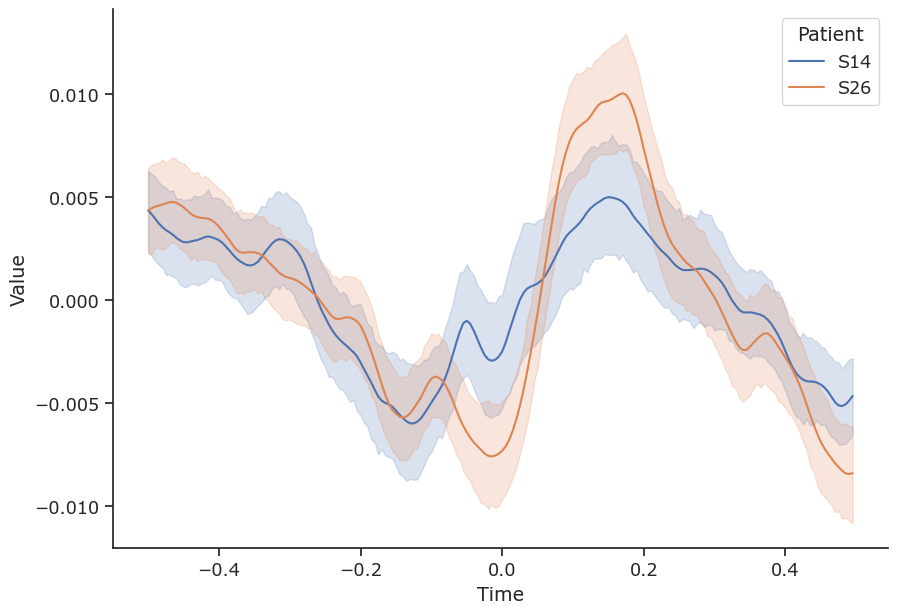

In [295]:
sns.set_theme(context='notebook', font='Verdana', font_scale=1.15, style='ticks')
f,ax = plt.subplots(1,1,figsize=(10,7))
sns.lineplot(data=algn_long_df[algn_long_df['CC'] == 5], x='Time', y='Value', hue='Patient', markers=False, dashes=False, ax=ax)
sns.despine()
plt.show()

### (M)CCA Maps

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def chan_disp(data, chan_map, title, label, figsize=(8, 6)):
    chan_data = np.array([data[int(i)] if not np.isnan(i) else np.nan for i in (chan_map.flatten()-1)])
    chan_data = chan_data.reshape(chan_map.shape)
    f = plt.figure(figsize=figsize)
    im = plt.imshow(chan_data)
    # plt.gca().invert_yaxis()
    # plt.contourf(chan_data, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes('right', size='5%', pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(label)
    
    plt.show()

In [29]:
from alignment.alignment_utils import extract_group_conditions
from alignment.AlignMCCA import n_components_var
from mvlearn.embed import MCCA

In [30]:
all_pt_data = [all_pt_traces[pt] for pt in pt_names]
all_pt_pseqs = [all_pt_phon_seqs[pt] for pt in pt_names]

#### MCCA fitting (significant electrodes)

In [90]:
n_comp = 25
pca_var = 0.9
ranks = [n_components_var(x.reshape(-1, x.shape[-1]), pca_var) for x in all_pt_data]

cnd_avg_data = extract_group_conditions(all_pt_data, all_pt_pseqs)
cnd_avg_data = [d.reshape(-1, d.shape[-1]) for d in cnd_avg_data]

mcca = MCCA(n_components=n_comp, regs=0.5, signal_ranks=ranks)
mcca_scores = mcca.fit_transform(cnd_avg_data)

In [91]:
mcca_corrs = mcca.canon_corrs(mcca_scores)
print(mcca_corrs.shape)
# print(mcca_corrs)

# average across non diagonal elements in correlation matrices
weights = (mcca_corrs != 1).astype(int)
pt_corrs = np.average(mcca_corrs, weights=weights, axis=1).T
print(pt_corrs.shape)

(25, 8, 8)
(8, 25)


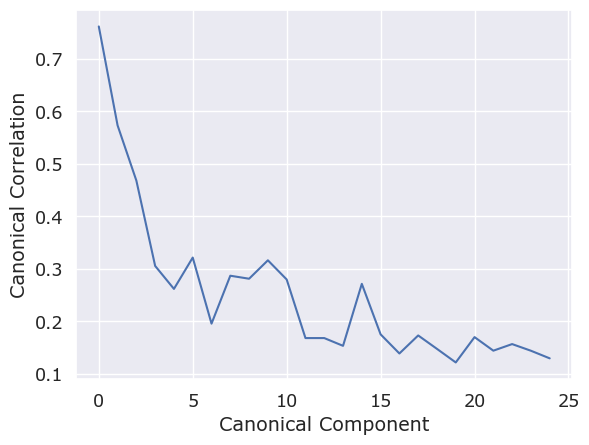

In [92]:
plt.figure()
plt.plot(pt_corrs[0])
plt.xlabel('Canonical Component')
plt.ylabel('Canonical Correlation')
plt.show()

#### Propagate MCCA correlations up

In [126]:
prop_comps = 2
pt_mcca_elecs = {}
for i, (corrs, pt) in enumerate(zip(pt_corrs, pt_names)):
    # print(i, pt)
    pt_loading = mcca.loadings_[i]
    loading_inv = np.linalg.pinv(pt_loading)
    corr_elecs = np.dot(corrs[:prop_comps], loading_inv[:prop_comps, :])
    pt_mcca_elecs[pt] = np.full(np.prod(all_pt_chan_data[pt]['map'].shape), np.nan)
    pt_mcca_elecs[pt][all_pt_chan_data[pt]['sig'].flatten()] = corr_elecs
    print(pt_mcca_elecs[pt].shape)

(128,)
(128,)
(128,)
(288,)
(128,)
(288,)
(288,)
(288,)


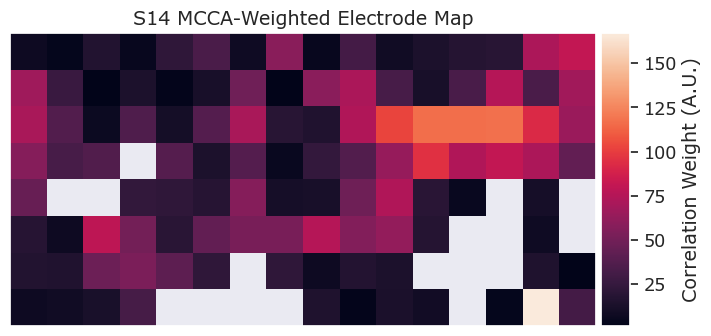

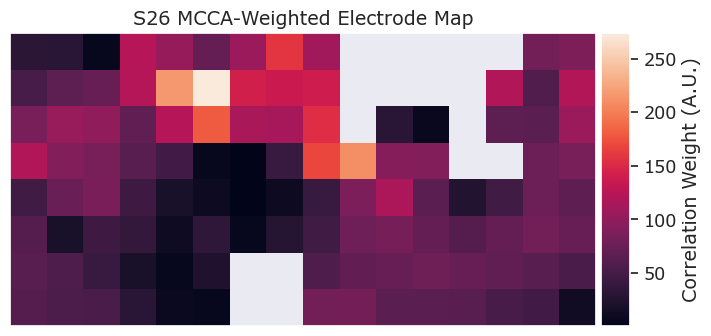

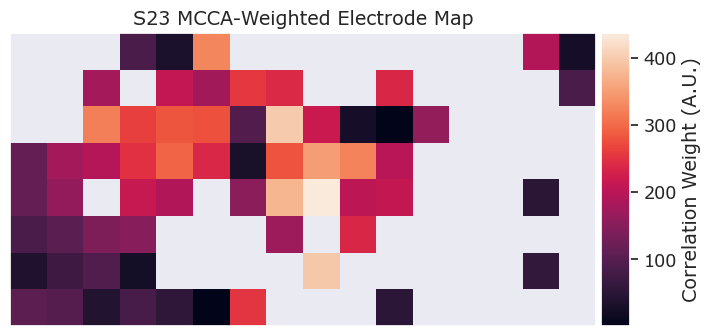

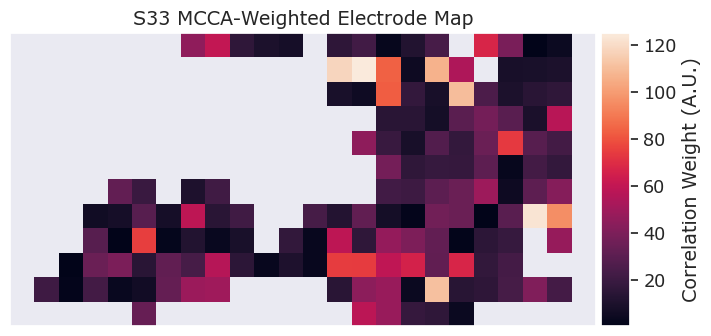

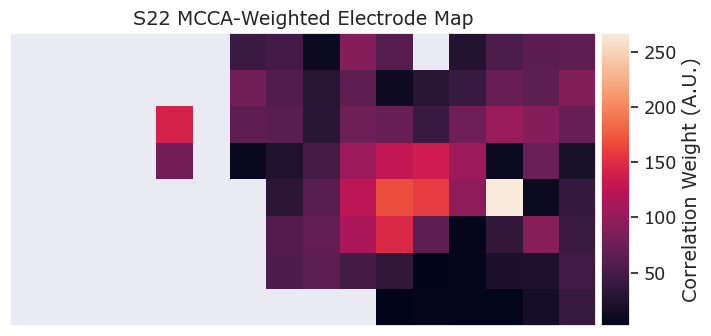

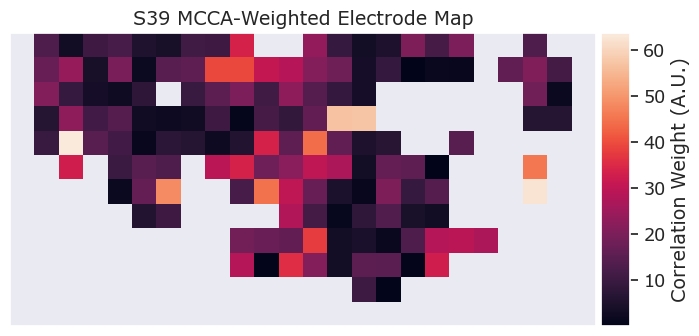

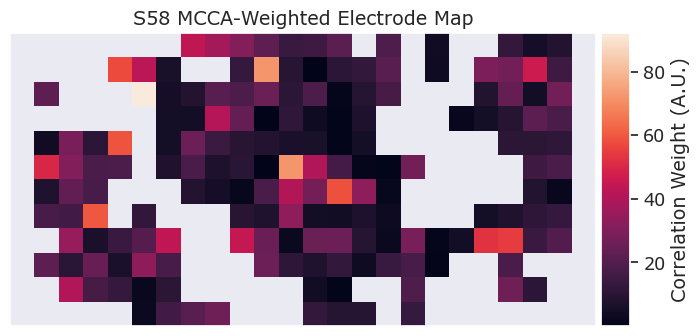

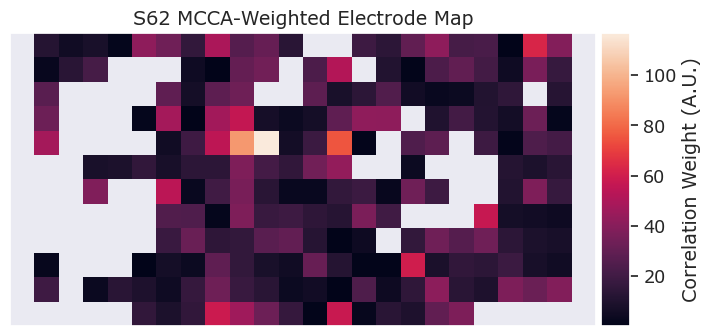

In [138]:
for pt, elecs in pt_mcca_elecs.items():
    chan_disp(np.abs(elecs), np.flipud(all_pt_chan_data[pt]['map']), f'{pt} MCCA-Weighted Electrode Map', 'Correlation Weight (A.U.)', figsize=(8,6))

In [128]:
sig_mcca_elecs = 0
sig_total_elecs = 0
for pt, elecs in pt_mcca_elecs.items():
    # count number of electrodes with correlation weights above 10th percentile
    # sig_mcca_elecs += np.sum(elecs >= np.nanpercentile(elecs, 10))
    thresh = 0.2 * np.nanmax(elecs)
    sig_mcca_elecs += np.sum(elecs >= thresh)
    # print(np.nanmean(elecs), np.nanpercentile(elecs, 10))
    sig_total_elecs += elecs.shape[0]
print(f'{sig_mcca_elecs} significant aligned electrodes out of {sig_total_elecs} total electrodes ({sig_mcca_elecs/sig_total_elecs:.2f})')

383 significant aligned electrodes out of 1664 total electrodes (0.23)


#### MCCA fitting (all electrodes)

In [20]:
all_pt_elec_data = [np.transpose(all_pt_dict[pt]['X1_map'].reshape(all_pt_dict[pt]['X1_map'].shape[0], -1, all_pt_dict[pt]['X1_map'].shape[-1]), axes=(0,2,1)) for pt in pt_names]
all_pt_good_idx = []
for i, (pt, d) in enumerate(zip(pt_names, all_pt_elec_data)):
    d[d == 0] = np.nan
    all_pt_good_idx.append(np.where(~np.isnan(d)))
    all_pt_elec_data[i] = d[np.where(~np.isnan(d))].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1)
# all_pt_elec_data = [x[~np.isnan(x).all(axis=(12))] for x in all_pt_elec_data]
print([x.shape for x in all_pt_elec_data])
print([x[0].shape for x in all_pt_good_idx])

[(144, 200, 128), (148, 200, 128), (151, 200, 128), (46, 200, 256), (151, 200, 128), (137, 200, 256), (141, 200, 256), (178, 200, 256)]
[(3686400,), (3788800,), (3865600,), (2355200,), (3865600,), (7014400,), (7219200,), (9113600,)]


In [25]:
n_comp = 25
pca_var = 0.9
ranks = [n_components_var(x.reshape(-1, x.shape[-1]), pca_var) for x in all_pt_data]

cnd_avg_data_all = extract_group_conditions(all_pt_elec_data, all_pt_pseqs)
# print([d.shape for d in cnd_avg_data])
cnd_avg_data_all = [d.reshape(-1, d.shape[-1]) for d in cnd_avg_data_all]

mcca_all = MCCA(n_components=n_comp, regs=0.5, signal_ranks=ranks)
mcca_all_scores = mcca_all.fit_transform(cnd_avg_data_all)

In [26]:
mcca_all_corrs = mcca_all.canon_corrs(mcca_all_scores)
print(mcca_all_corrs.shape)
# print(mcca_corrs)

# average across non diagonal elements in correlation matrices
weights_all = (mcca_all_corrs != 1).astype(int)
pt_corrs_all = np.average(mcca_all_corrs, weights=weights_all, axis=1).T
print(pt_corrs_all.shape)

(25, 8, 8)
(8, 25)


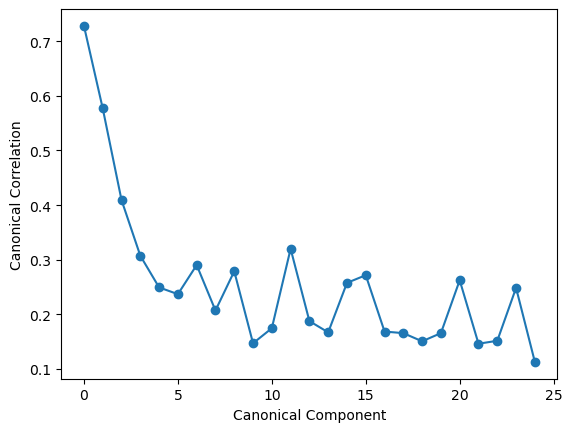

In [27]:
plt.figure()

plt.plot(pt_corrs_all[0], '-o')
plt.xlabel('Canonical Component')
plt.ylabel('Canonical Correlation')
plt.show()

#### Propagate MCCA-weighted activity up

In [28]:
prop_comps = [1,2]

# pt_mcca_timeseries = {}
# for i, (corrs, pt) in enumerate(zip(pt_corrs, pt_names)):
#     # print(i, pt)
#     # calcuate mcca projection
#     to_transform = all_pt_traces[pt].reshape(-1, all_pt_traces[pt].shape[-1])
#     mcca_data = mcca.transform_view(to_transform, i)
#     # weight activity by canonical correlation
#     corr_activ = mcca_data * corrs

#     # get mapping back to electrode space
#     pt_loading = mcca.loadings_[i]
#     loading_inv = np.linalg.pinv(pt_loading)

#     # map correlation weighted activity back to electrode space
#     corr_elecs = np.dot(corr_activ[:, prop_comps[0]:prop_comps[1]], loading_inv[prop_comps[0]:prop_comps[1], :])
#     corr_elecs = corr_elecs.reshape(all_pt_traces[pt].shape[0],
#                                     all_pt_traces[pt].shape[1],
#                                     -1)
#     pt_mcca_timeseries[pt] = {}
#     pt_mcca_timeseries[pt]['MCCA'] = np.full((all_pt_traces[pt].shape[0],
#                                  all_pt_traces[pt].shape[1],
#                                  np.prod(all_pt_chan_data[pt]['map'].shape)),
#                                  np.nan)
#     pt_mcca_timeseries[pt]['MCCA'][:,:,all_pt_chan_data[pt]['sig'].flatten()] = corr_elecs
    
#     pt_mcca_timeseries[pt]['MCCA'] = np.nan_to_num(pt_mcca_timeseries[pt]['MCCA'], nan=0)

#     pt_mcca_timeseries[pt]['Reg'] = np.full((all_pt_traces[pt].shape[0],
#                                  all_pt_traces[pt].shape[1],
#                                  np.prod(all_pt_chan_data[pt]['map'].shape)),
#                                  np.nan)
#     pt_mcca_timeseries[pt]['Reg'][:,:,all_pt_chan_data[pt]['sig'].flatten()] = all_pt_traces[pt]
#     pt_mcca_timeseries[pt]['Reg'] = np.nan_to_num(pt_mcca_timeseries[pt]['Reg'], nan=0)

#     print(pt_mcca_timeseries[pt]['MCCA'].shape, pt_mcca_timeseries[pt]['Reg'].shape)

elec_data_full = [np.transpose(all_pt_dict[pt]['X1_map'].reshape(all_pt_dict[pt]['X1_map'].shape[0], -1, all_pt_dict[pt]['X1_map'].shape[-1]), axes=(0,2,1)) for pt in pt_names]

pt_mcca_timeseries = {}
for i, (corrs, pt) in enumerate(zip(pt_corrs_all, pt_names)):
    # print(i, pt)
    # calcuate mcca projection
    to_transform = all_pt_elec_data[i].reshape(-1, all_pt_elec_data[i].shape[-1])
    mcca_data = mcca_all.transform_view(to_transform, i)
    # weight activity by canonical correlation
    corr_activ = mcca_data * corrs

    # get mapping back to electrode space
    pt_loading = mcca_all.loadings_[i]
    loading_inv = np.linalg.pinv(pt_loading)

    # map correlation weighted activity back to electrode space
    corr_elecs = np.dot(corr_activ[:,prop_comps[0]:prop_comps[1]], loading_inv[prop_comps[0]:prop_comps[1], :])
    corr_elecs = corr_elecs.reshape(all_pt_traces[pt].shape[0],
                                    all_pt_traces[pt].shape[1],
                                    -1)
    pt_mcca_timeseries[pt] = {}
    pt_mcca_timeseries[pt]['MCCA'] = np.full((all_pt_traces[pt].shape[0],
                                 all_pt_traces[pt].shape[1],
                                 np.prod(all_pt_chan_data[pt]['map'].shape)),
                                 np.nan)
    pt_mcca_timeseries[pt]['MCCA'][all_pt_good_idx[i]] = corr_elecs.flatten()
    # pt_mcca_timeseries[pt]['MCCA'] = np.nan_to_num(pt_mcca_timeseries[pt]['MCCA'], nan=0)

    temp = elec_data_full[i]
    temp[temp == 0] = np.nan
    pt_mcca_timeseries[pt]['Reg'] = temp

    print(pt_mcca_timeseries[pt]['MCCA'].shape, pt_mcca_timeseries[pt]['Reg'].shape)

(144, 200, 128) (144, 200, 128)
(148, 200, 128) (148, 200, 128)
(151, 200, 128) (151, 200, 128)
(46, 200, 288) (46, 200, 288)
(151, 200, 128) (151, 200, 128)
(137, 200, 288) (137, 200, 288)
(141, 200, 288) (141, 200, 288)
(178, 200, 288) (178, 200, 288)


##### for convenience of running cells

In [34]:
from alignment.alignment_utils import cnd_avg

In [202]:
def chan_disp_seq(data, chan_map, t, t_ranges, labs, title, label, figsize=(3, 6), cbar_pos=[0.81, 0.56, 0.01, 0.3], sup_pos=0.95, cbar_lower=None, cbar_upper=None):
    f, tot_axs = plt.subplots(len(labs), len(t_ranges), figsize=(figsize[0]*len(t_ranges), figsize[1]*len(labs)))

    if len(labs) == 1:
        tot_axs = tot_axs[np.newaxis,:]

    mean_val = np.nanmean(data)
    std_val = np.nanstd(data)
    std_mult = 3
    # clim = [max(0, mean_val - std_mult*std_val), mean_val + std_mult*std_val]
    if cbar_lower is None:
        cbar_lower = mean_val - std_mult*std_val
    if cbar_upper is None:
        cbar_upper = mean_val + std_mult*std_val
    clim = [cbar_lower, cbar_upper]

    for j, lab in enumerate(labs):
        lab_data = data[j]
        axs = tot_axs[j]
        for i, t_range in enumerate(t_ranges):
            t_inds = np.where((t >= t_range[0]) & (t < t_range[1]))[0]
            chan_data = np.array([lab_data[t_inds,:].mean(axis=0)[int(k)] if not np.isnan(k) else np.nan for k in (chan_map.flatten()-1)])
            chan_data = chan_data.reshape(chan_map.shape)
            im = axs[i].imshow(chan_data, cmap=parula_map)
            im.set_clim(clim[0], clim[1])
            if i==0:
                axs[i].set_ylabel(lab)
            if j==0:
                axs[i].set_title(f'{t_range[0]} -> {t_range[1]}s')
            axs[i].set_xticks([])
            axs[i].set_yticks([])
            

        # divider = make_axes_locatable(plt.gca())
        # cax = divider.append_axes('right', size='5%', pad=0.05)

        # cbar = plt.colorbar(im, cax=cax)
        
        # cbar.set_label(label)
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes(cbar_pos)
    cbar = f.colorbar(im, cax=cbar_ax)
    cbar.set_label(label)

    # f.tight_layout(rect=[0, 0.03, 1, 0.95])
    f.suptitle(title, y=sup_pos)
    plt.show()

##### asdf

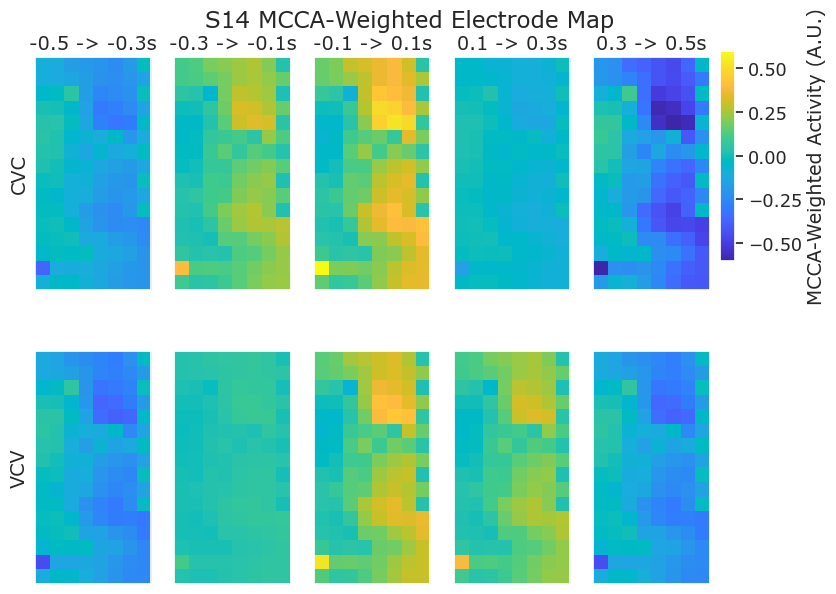

In [32]:
sns.set_theme(context='notebook', font='Verdana', font_scale=1.15)

pt = 'S14'
# cnd_labels = all_pt_phon_labels[pt]
# lab_names = phon_labels
# cnd_labels = all_pt_artic_labels[pt]
# lab_names = artic_labels
cnd_labels = all_pt_cv_labels[pt]
lab_names = ['CVC', 'VCV']
mcca_avg = cnd_avg(pt_mcca_timeseries[pt]['MCCA'], cnd_labels)
reg_avg = cnd_avg(pt_mcca_timeseries[pt]['Reg'], cnd_labels)


t_ranges = [[-0.5, -0.3], [-0.3, -0.1], [-0.1, 0.1], [0.1, 0.3], [0.3, 0.5]]

if all_pt_chan_data[pt]['map'].size == 128:
    # chan_map = all_pt_chan_data[pt]['map'].T
    chan_map = np.arange(128).reshape(8,16).T+1
    figsize=(2,3.5)
    cbar_pos = [0.81, 0.58, 0.015, 0.3]
    sup_pos = 0.94
else:
    # chan_map = np.flipud(all_pt_chan_data[pt]['map'])
    chan_map = np.fliplr(np.flipud(np.arange(288).reshape(12,24)))+1
    figsize=(4,2)
    cbar_pos = [0.81, 0.56, 0.01, 0.3]
    sup_pos = 0.98
chan_disp_seq(mcca_avg, chan_map, t, t_ranges, lab_names, f'{pt} MCCA-Weighted Electrode Map', 'MCCA-Weighted Activity (A.U.)', figsize=figsize, cbar_pos=cbar_pos, sup_pos=sup_pos)
# chan_disp_seq(np.abs(reg_avg), chan_map, t, t_ranges, lab_names, f'{pt} Regular Electrode Map', 'HG Z-score', figsize=figsize, cbar_pos=cbar_pos, sup_pos=sup_pos)


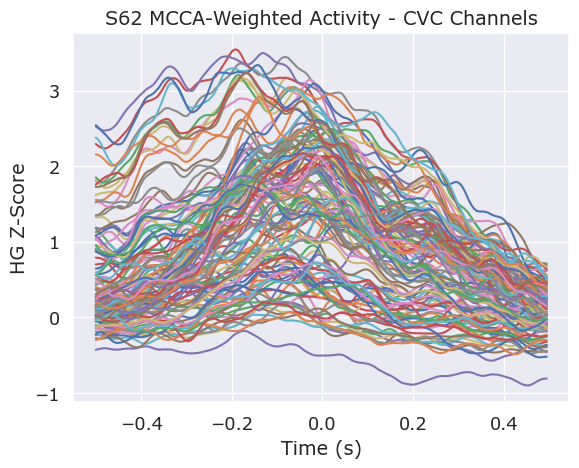

In [96]:
plt.figure()

# plt.plot(t, mcca_avg[0])
# plt.ylabel('MCCA-Weighted Activity')

plt.plot(t, reg_avg[0])
plt.ylabel('HG Z-Score')

plt.xlabel('Time (s)')
plt.title(f'{pt} MCCA-Weighted Activity - CVC Channels')
plt.show()

#### MCCA correlation with HG Z-score

In [338]:
t_range = [-0.1, 0.1]
t_inds = np.where((t >= t_range[0]) & (t < t_range[1]))[0]
mcca_corr_data = []
reg_corr_data = []
# for pt in ['S14', 'S26', 'S23', 'S33']:
for pt in pt_names:
    d_mcca = np.mean(np.mean(pt_mcca_timeseries[pt]['MCCA'][:,t_inds,:], axis=1), axis=0).flatten()
    # d_mcca = np.mean(pt_mcca_timeseries[pt]['MCCA'][:,t_inds,:], axis=1).flatten()

    # remove nans
    d_mcca = d_mcca[~np.isnan(d_mcca)]
    

    d_reg = np.mean(np.mean(pt_mcca_timeseries[pt]['Reg'][:,t_inds,:], axis=1), axis=0).flatten()
    # d_reg = np.mean(pt_mcca_timeseries[pt]['Reg'][:,t_inds,:], axis=1).flatten()

    # remove nans
    d_reg = d_reg[~np.isnan(d_reg)]

    # # remove reg outliers (3 standard deviations from mean)
    # d_reg = d_reg[np.abs(d_reg - np.nanmean(d_reg)) < 3*np.nanstd(d_reg)]

    # remove mcca outliers (3 standard deviations from mean)
    outlier_idx_mcca = np.abs(d_mcca - np.mean(d_mcca)) >= 3*np.std(d_mcca)
    outlier_idx_reg = np.abs(d_reg - np.mean(d_reg)) >= 3*np.std(d_reg)
    outlier_idx = np.logical_or(outlier_idx_mcca, outlier_idx_reg)
    d_mcca = d_mcca[~outlier_idx]
    d_reg = d_reg[~outlier_idx]

    # mcca_corr_data.append(d_mcca[d_mcca != 0])
    mcca_corr_data.append(d_mcca)

    # reg_corr_data.append(d_reg[d_reg != 0])
    reg_corr_data.append(d_reg)

# mcca_corr_data = np.array(mcca_corr_data)
# reg_corr_data = np.array(reg_corr_data)

print([x.shape for x in mcca_corr_data])
print([x.shape for x in reg_corr_data])



[(110,), (109,), (62,), (145,), (71,), (143,), (170,), (196,)]
[(110,), (109,), (62,), (145,), (71,), (143,), (170,), (196,)]


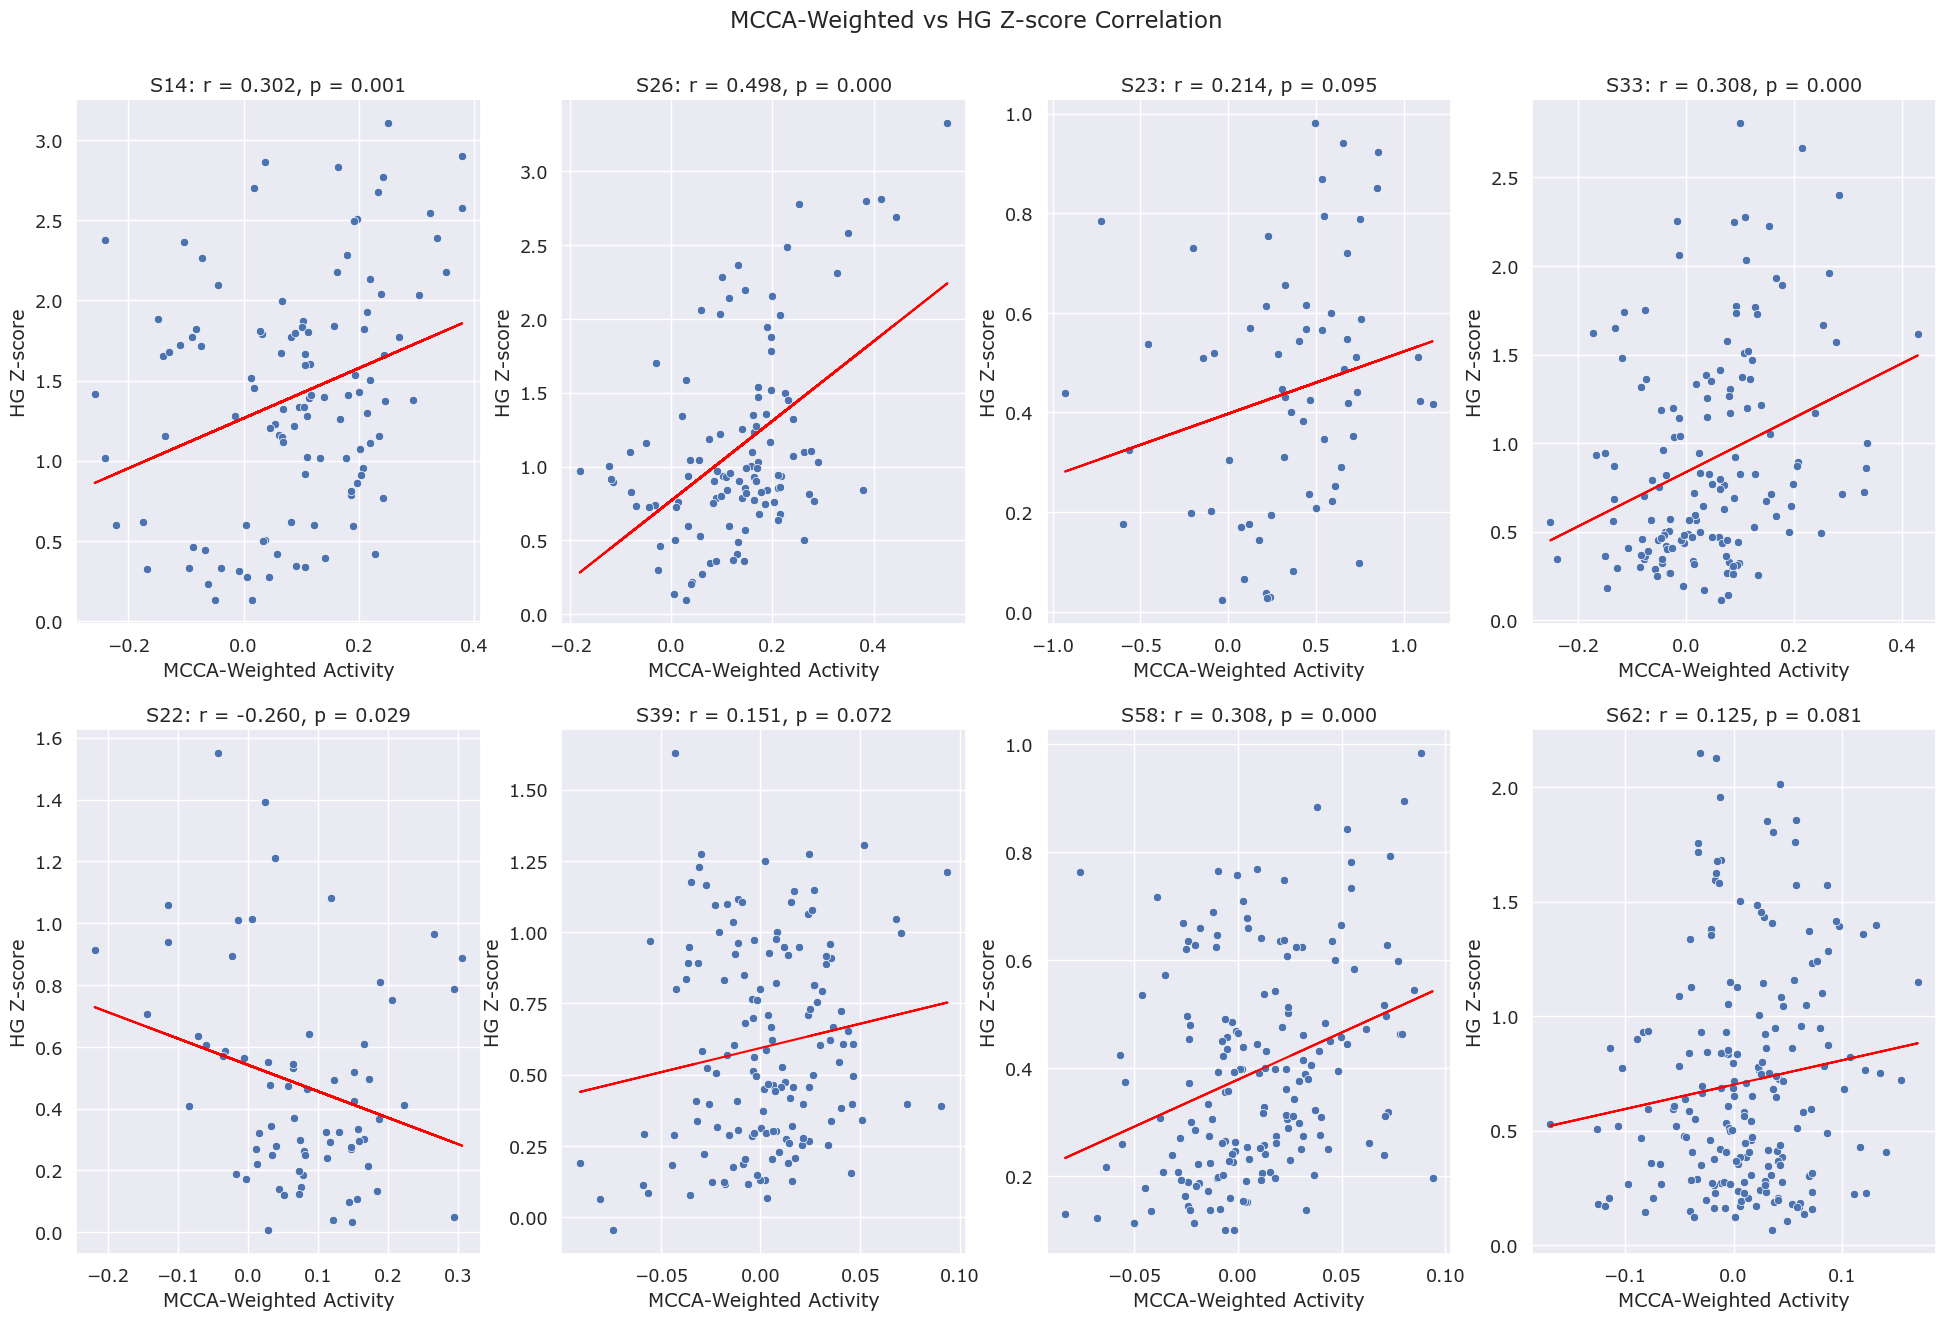

In [328]:
from scipy.stats import linregress

f, axs = plt.subplots(2, int(len(pt_names)/2), figsize=(6*len(pt_names)/2, 15))
axs = axs.flatten()
for i, pt in enumerate(pt_names):
    # calculate relationship between MCCA-Weighted and Regular HG Z-score
    slope, intercept, r_value, p_value, std_err = linregress(mcca_corr_data[i], reg_corr_data[i])
    # print(slope, intercept, r_value, p_value, std_err)
    sns.scatterplot(x=mcca_corr_data[i], y=reg_corr_data[i], ax=axs[i])
    axs[i].plot(mcca_corr_data[i], slope*mcca_corr_data[i] + intercept, color='red')
    axs[i].set_xlabel('MCCA-Weighted Activity')
    axs[i].set_ylabel('HG Z-score')
    axs[i].set_title(f'{pt}: r = {r_value:.3f}, p = {p_value:.3f}')
plt.suptitle('MCCA-Weighted vs HG Z-score Correlation', y=0.94)
plt.show()

In [340]:
mcca_time_data = []
reg_time_data = []
# for pt in ['S14', 'S26', 'S23', 'S33']:
for pt in pt_names:
    d_mcca = pt_mcca_timeseries[pt]['MCCA']
    # remove nans
    d_mcca = d_mcca[~np.isnan(d_mcca)].reshape(all_pt_traces[pt].shape)

    d_mcca = np.mean(np.mean(d_mcca, axis=0), axis=1).flatten()
    # d_mcca = np.mean(pt_mcca_timeseries[pt]['MCCA'][:,t_inds,:], axis=1).flatten()

    d_reg = pt_mcca_timeseries[pt]['Reg']
    # remove nans
    d_reg = d_reg[~np.isnan(d_reg)].reshape(all_pt_traces[pt].shape)
    
    d_reg = np.mean(np.mean(d_reg, axis=0), axis=1).flatten()
    # d_reg = np.mean(pt_mcca_timeseries[pt]['Reg'][:,t_inds,:], axis=1).flatten()

    # mcca_corr_data.append(d_mcca[d_mcca != 0])
    mcca_time_data.append(d_mcca)

    # reg_corr_data.append(d_reg[d_reg != 0])
    reg_time_data.append(d_reg)

# mcca_corr_data = np.array(mcca_corr_data)
# reg_corr_data = np.array(reg_corr_data)

print([x.shape for x in mcca_time_data])
print([x.shape for x in reg_time_data])

[(200,), (200,), (200,), (200,), (200,), (200,), (200,), (200,)]
[(200,), (200,), (200,), (200,), (200,), (200,), (200,), (200,)]


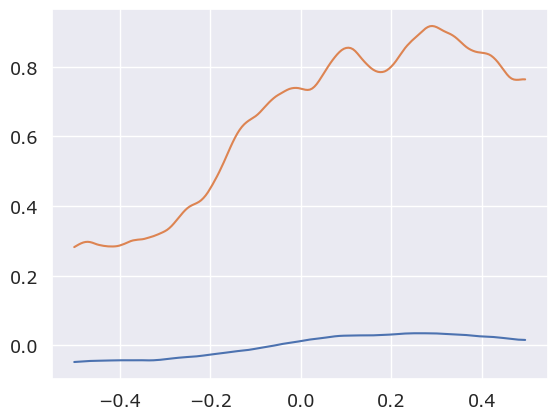

In [352]:
plt.figure()
plt.plot(t, mcca_time_data[7])
plt.plot(t, reg_time_data[7])
plt.show()

#### CCA fitting (All electrodes)

In [23]:
all_pt_elec_data = [np.transpose(all_pt_dict[pt]['X1_map'].reshape(all_pt_dict[pt]['X1_map'].shape[0], -1, all_pt_dict[pt]['X1_map'].shape[-1]), axes=(0,2,1)) for pt in pt_names]
all_pt_good_idx = []
for i, (pt, d) in enumerate(zip(pt_names, all_pt_elec_data)):
    d[d == 0] = np.nan
    all_pt_good_idx.append(np.where(~np.isnan(d)))
    all_pt_elec_data[i] = d[np.where(~np.isnan(d))].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1)
# all_pt_elec_data = [x[~np.isnan(x).all(axis=(12))] for x in all_pt_elec_data]
print([x.shape for x in all_pt_elec_data])
print([x[0].shape for x in all_pt_good_idx])

[(144, 200, 128), (148, 200, 128), (151, 200, 128), (46, 200, 256), (151, 200, 128), (137, 200, 256), (141, 200, 256), (178, 200, 256)]
[(3686400,), (3788800,), (3865600,), (2355200,), (3865600,), (7014400,), (7219200,), (9113600,)]


In [25]:
def pt_corr_comp(target, to_corr, target_labels, to_corr_labels, n_comp=25):
    min_dim = min(target.shape[-1], to_corr.shape[-1], n_comp)
    
    # Extract condition-averaged data
    cnd_avg_data = utils.extract_group_conditions([target, to_corr], [target_labels, to_corr_labels])
    
    # Precompute dimensions
    n_cnds = cnd_avg_data[0].shape[0]
    target_avg = cnd_avg_data[0][:,:,:min_dim]
    to_corr_avg = cnd_avg_data[1][:,:,:min_dim]
    
    # Use np.zeros to store correlations
    corrs = np.zeros((n_cnds, min_dim))
    
    # Compute correlations
    for j in range(min_dim):
        # Vectorized Pearson correlation for all conditions at once
        target_data = target_avg[:,:,j]
        to_corr_data = to_corr_avg[:,:,j]
        
        # Mean and std for target and to_corr
        target_mean = np.mean(target_data, axis=1, keepdims=True)
        to_corr_mean = np.mean(to_corr_data, axis=1, keepdims=True)
        
        target_std = np.std(target_data, axis=1, ddof=1, keepdims=True)
        to_corr_std = np.std(to_corr_data, axis=1, ddof=1, keepdims=True)
        
        # Compute Pearson correlations manually
        cov = np.mean((target_data - target_mean) * (to_corr_data - to_corr_mean), axis=1)
        corrs[:, j] = cov / (target_std.flatten() * to_corr_std.flatten())
    
    # Average correlations across conditions
    avg_corrs = np.mean(corrs, axis=0)
    
    return avg_corrs

In [31]:
from sklearn.decomposition import PCA

n_comp = 15
pca_var = 0.9
pt_dr = [PCA(n_components=pca_var) for _ in pt_names]
pt_data_dr = [dr.fit_transform(all_pt_elec_data[i].reshape(-1, all_pt_elec_data[i].shape[-1])).reshape(all_pt_elec_data[i].shape[0], all_pt_elec_data[i].shape[1], -1) for i, dr in enumerate(pt_dr)]

pt_corrs_cca = np.zeros((len(pt_names), n_comp))
for i, pt in enumerate(pt_names):
    target_dr = pt_data_dr[i]
    align_corrs = []
    for j, cpt in enumerate(pt_names):
        if pt == cpt:
            continue
        aligner = AlignCCA()
        aligner.fit(target_dr, pt_data_dr[j], all_pt_phon_seqs[pt], all_pt_phon_seqs[cpt])
        cross_aligned = aligner.transform(pt_data_dr[j])
        canon_corrs = aligner.canon_corrs

        # calculate correlation between target and aligned data
        # start = time.time()
        # corrs = pt_corr_comp(target_dr, cross_aligned, all_pt_phon_seqs[pt], all_pt_phon_seqs[cpt], n_comp=n_comp)
        # corr_time = time.time() - start

        start = time.time()
        corrs = pt_corr_comp(target_dr, cross_aligned, all_pt_phon_seqs[pt], all_pt_phon_seqs[cpt], n_comp=n_comp)
        corr_time = time.time() - start

        # print(f'Corr time: {corr_time}')

        align_corrs.append(corrs)
    pt_corrs_cca[i] = np.mean(np.array(align_corrs), axis=0)

#### Propagate CCA-weighted activity up

In [430]:
prop_comps = [2,3]

elec_data_full = [np.transpose(all_pt_dict[pt]['X1_map'].reshape(all_pt_dict[pt]['X1_map'].shape[0], -1, all_pt_dict[pt]['X1_map'].shape[-1]), axes=(0,2,1)) for pt in pt_names]

pt_cca_timeseries = {}
for i, (corrs, pt) in enumerate(zip(pt_corrs_cca, pt_names)):
    # print(i, pt)

    # use target latent dynamics - no need to transform since patients are aligned to target patient's space
    lat_dyn_tar = pt_data_dr[i][:,:,:n_comp].reshape(-1, n_comp)

    # weight activity by canonical correlation
    corr_activ = lat_dyn_tar * corrs
    # corr_activ = lat_dyn_tar
    corr_activ = corr_activ[:,prop_comps[0]:prop_comps[1]]

    # get mapping back to electrode space
    # pt_loading = cca_all.loadings_[i]
    # loading_inv = np.linalg.pinv(pt_loading)
    tar_dr = pt_dr[i]
    tform_mat = tar_dr.components_[:n_comp]
    tform_mat = tform_mat[prop_comps[0]:prop_comps[1], :]

    # map correlation weighted activity back to electrode space
    # corr_elecs = np.dot(corr_activ[:,prop_comps[0]:prop_comps[1]], loading_inv[prop_comps[0]:prop_comps[1], :])
    # corr_elecs = corr_activ @ tform_mat + tar_dr.mean_
    corr_elecs = corr_activ @ tform_mat
    corr_elecs = corr_elecs.reshape(all_pt_traces[pt].shape[0],
                                    all_pt_traces[pt].shape[1],
                                    -1)
    pt_cca_timeseries[pt] = {}
    pt_cca_timeseries[pt]['CCA'] = np.full((all_pt_traces[pt].shape[0],
                                 all_pt_traces[pt].shape[1],
                                 np.prod(all_pt_chan_data[pt]['map'].shape)),
                                 np.nan)
    pt_cca_timeseries[pt]['CCA'][all_pt_good_idx[i]] = corr_elecs.flatten()
    # pt_cca_timeseries[pt]['CCA'] = np.nan_to_num(pt_cca_timeseries[pt]['CCA'], nan=0)

    temp = elec_data_full[i]
    temp[temp == 0] = np.nan
    pt_cca_timeseries[pt]['Reg'] = temp

    print(pt_cca_timeseries[pt]['CCA'].shape, pt_cca_timeseries[pt]['Reg'].shape)


(144, 200, 128) (144, 200, 128)
(148, 200, 128) (148, 200, 128)
(151, 200, 128) (151, 200, 128)
(46, 200, 288) (46, 200, 288)
(151, 200, 128) (151, 200, 128)
(137, 200, 288) (137, 200, 288)
(141, 200, 288) (141, 200, 288)
(178, 200, 288) (178, 200, 288)


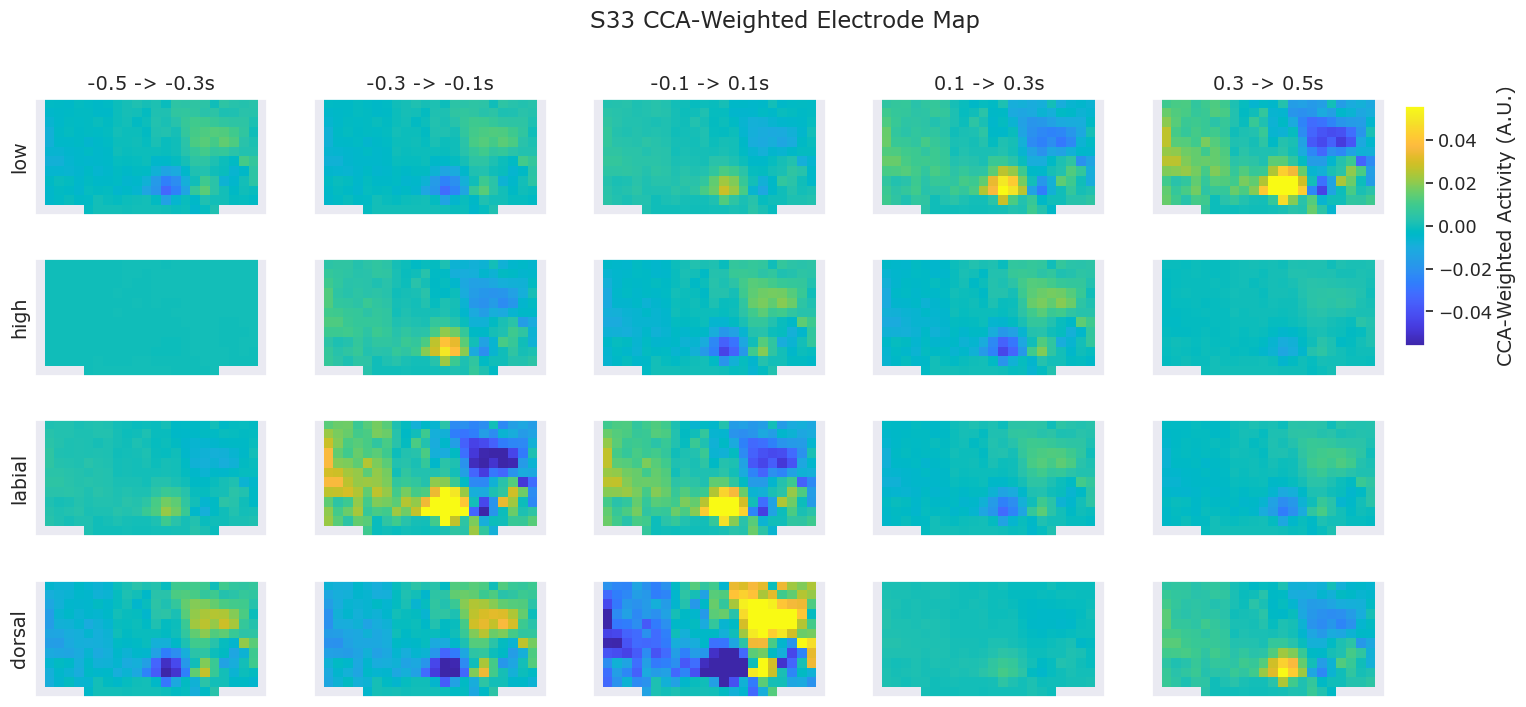

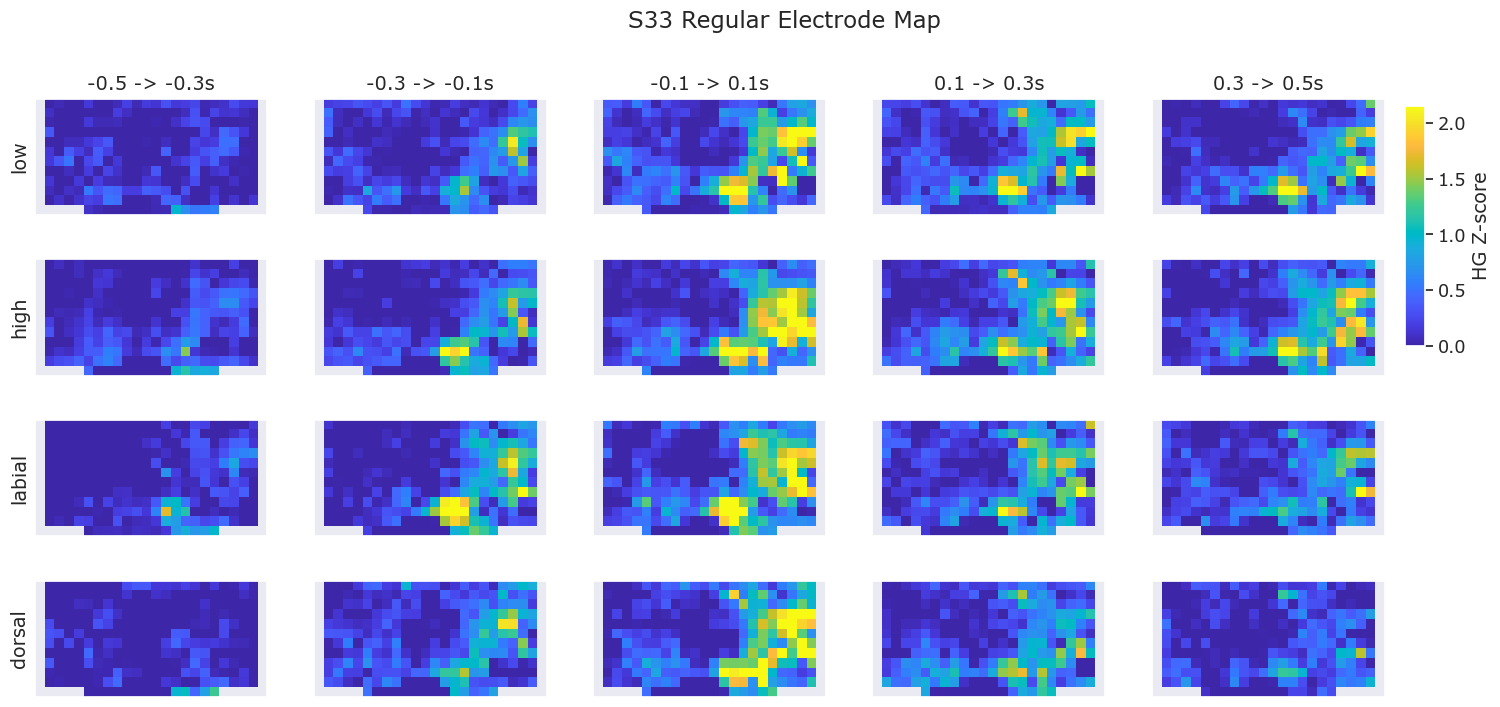

In [431]:
sns.set_theme(context='notebook', font='Verdana', font_scale=1.15)

pt = 'S33'
# cnd_labels = all_pt_phon_labels[pt]; lab_names = phon_labels
cnd_labels = all_pt_artic_labels[pt]; lab_names = artic_labels
# cnd_labels = all_pt_cv_labels[pt]; lab_names = ['CVC', 'VCV']
# cnd_labels = np.ones(all_pt_cv_labels[pt].shape); lab_names = ['All Trials']
cca_avg = cnd_avg(pt_cca_timeseries[pt]['CCA'], cnd_labels)
reg_avg = cnd_avg(pt_cca_timeseries[pt]['Reg'], cnd_labels)


t_ranges = [[-0.5, -0.3], [-0.3, -0.1], [-0.1, 0.1], [0.1, 0.3], [0.3, 0.5]]

if all_pt_chan_data[pt]['map'].size == 128:
    # chan_map = all_pt_chan_data[pt]['map'].T
    chan_map = np.arange(128).reshape(8,16).T+1
    figsize=(2,3.5)
    cbar_pos = [0.81, 0.58, 0.015, 0.3]
    sup_pos = 0.94
else:
    # chan_map = np.flipud(all_pt_chan_data[pt]['map'])-1
    if pt == 'S33':
        chan_map = np.fliplr(np.flipud(np.arange(288).reshape(12,24)))+1
    elif pt == 'S39':
        chan_map = np.arange(288).reshape(24,12).T+1
    else:
        chan_map = np.flipud(np.arange(288).reshape(24,12).T)+1
    figsize=(4,2)
    cbar_pos = [0.81, 0.56, 0.01, 0.3]
    sup_pos = 0.98
chan_disp_seq(cca_avg, chan_map, t, t_ranges, lab_names, f'{pt} CCA-Weighted Electrode Map', 'CCA-Weighted Activity (A.U.)', figsize=figsize, cbar_pos=cbar_pos, sup_pos=sup_pos)
chan_disp_seq(reg_avg, chan_map, t, t_ranges, lab_names, f'{pt} Regular Electrode Map', 'HG Z-score', figsize=figsize, cbar_pos=cbar_pos, sup_pos=sup_pos, cbar_lower=0)

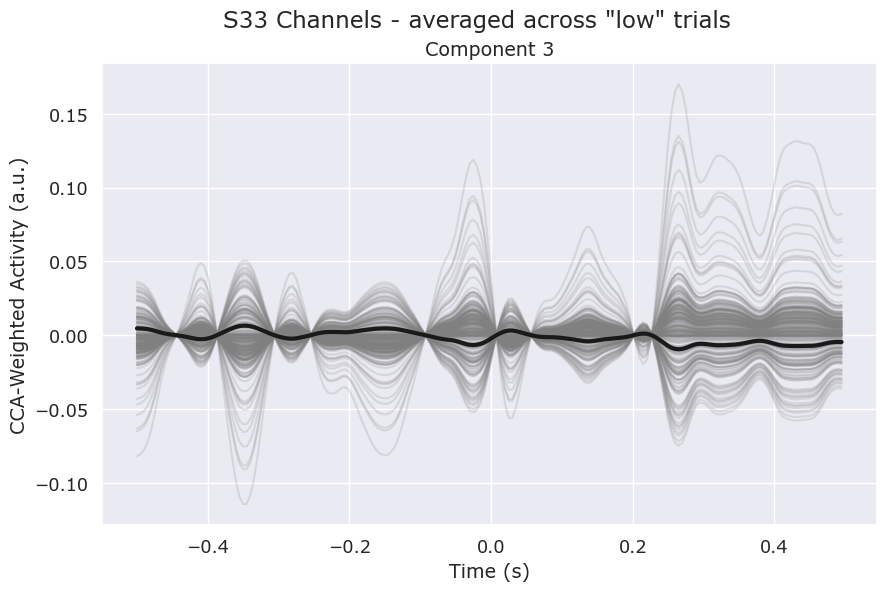

In [436]:
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
f, ax1 = plt.subplots(1, 1, figsize=(10,6))

label_ind = 0

ax1.plot(t, cca_avg[label_ind], 'gray', alpha=0.2)
ax1.plot(t, cca_avg[label_ind][:,5], 'k', linewidth=3)
# ax1.plot(t, np.nanmean(reg_avg[label_ind],axis=-1) - np.nanmean(np.nanmean(reg_avg[label_ind],axis=-1)), 'blue', linewidth=4, label='HG Z-Score (mean subtracted)')
# ax1.plot(t, np.nanmean(cca_avg[label_ind], axis=-1), 'red', linewidth=4, label='CCA-Weighted Mean')
ax1.set_ylabel('CCA-Weighted Activity (a.u.)')
ax1.set_xlabel('Time (s)')
# ax1.legend()
ax1.set_title('Component 3')

# ax2.plot(t, reg_avg[label_ind] - np.nanmean(reg_avg[label_ind]), 'gray', alpha=0.2)
# ax2.plot(t, np.nanmean(reg_avg[label_ind],axis=-1) - np.nanmean(np.nanmean(reg_avg[label_ind],axis=-1)), 'blue', linewidth=4, label='HG Z-Score (mean subtracted)')
# # ax2.plot(t, np.mean(reg_avg[label_ind] - np.nanmean(reg_avg[label_ind]).T))
# # ax2.plot(t, np.mean(reg_avg[label_ind],axis=-1))
# ax2.set_ylabel('HG Z-Score')
# ax2.set_xlabel('Time (s)')
# ax2.set_title('HG Z-Score')

plt.suptitle(f'{pt} Channels - averaged across "{lab_names[label_ind]}" trials', y=0.97)
plt.show()

#### CCA correlation with HG Z-Score

In [268]:
t_range = [-0.3, 0.3]
t_inds = np.where((t >= t_range[0]) & (t < t_range[1]))[0]
cca_corr_data = []
reg_corr_data = []
# for pt in ['S14', 'S26', 'S23', 'S33']:
for pt in pt_names:
    d_cca = np.mean(np.mean(pt_cca_timeseries[pt]['CCA'][:,t_inds,:], axis=1), axis=0).flatten()

    # remove nans
    d_cca = d_cca[~np.isnan(d_cca)]
    

    d_reg = np.mean(np.mean(pt_cca_timeseries[pt]['Reg'][:,t_inds,:], axis=1), axis=0).flatten()
    d_reg -= np.nanmean(d_reg)

    # remove nans
    d_reg = d_reg[~np.isnan(d_reg)]

    # # remove reg outliers (3 standard deviations from mean)
    # d_reg = d_reg[np.abs(d_reg - np.nanmean(d_reg)) < 3*np.nanstd(d_reg)]

    # remove mcca outliers (3 standard deviations from mean)
    outlier_idx_cca = np.abs(d_cca - np.mean(d_cca)) >= 3*np.std(d_cca)
    outlier_idx_reg = np.abs(d_reg - np.mean(d_reg)) >= 3*np.std(d_reg)
    outlier_idx = np.logical_or(outlier_idx_cca, outlier_idx_reg)
    d_cca = d_cca[~outlier_idx]
    d_reg = d_reg[~outlier_idx]

    # mcca_corr_data.append(d_mcca[d_mcca != 0])
    cca_corr_data.append(d_cca)

    # reg_corr_data.append(d_reg[d_reg != 0])
    reg_corr_data.append(d_reg)

# mcca_corr_data = np.array(mcca_corr_data)
# reg_corr_data = np.array(reg_corr_data)

print([x.shape for x in cca_corr_data])
print([x.shape for x in reg_corr_data])

[(127,), (125,), (126,), (250,), (120,), (250,), (253,), (247,)]
[(127,), (125,), (126,), (250,), (120,), (250,), (253,), (247,)]


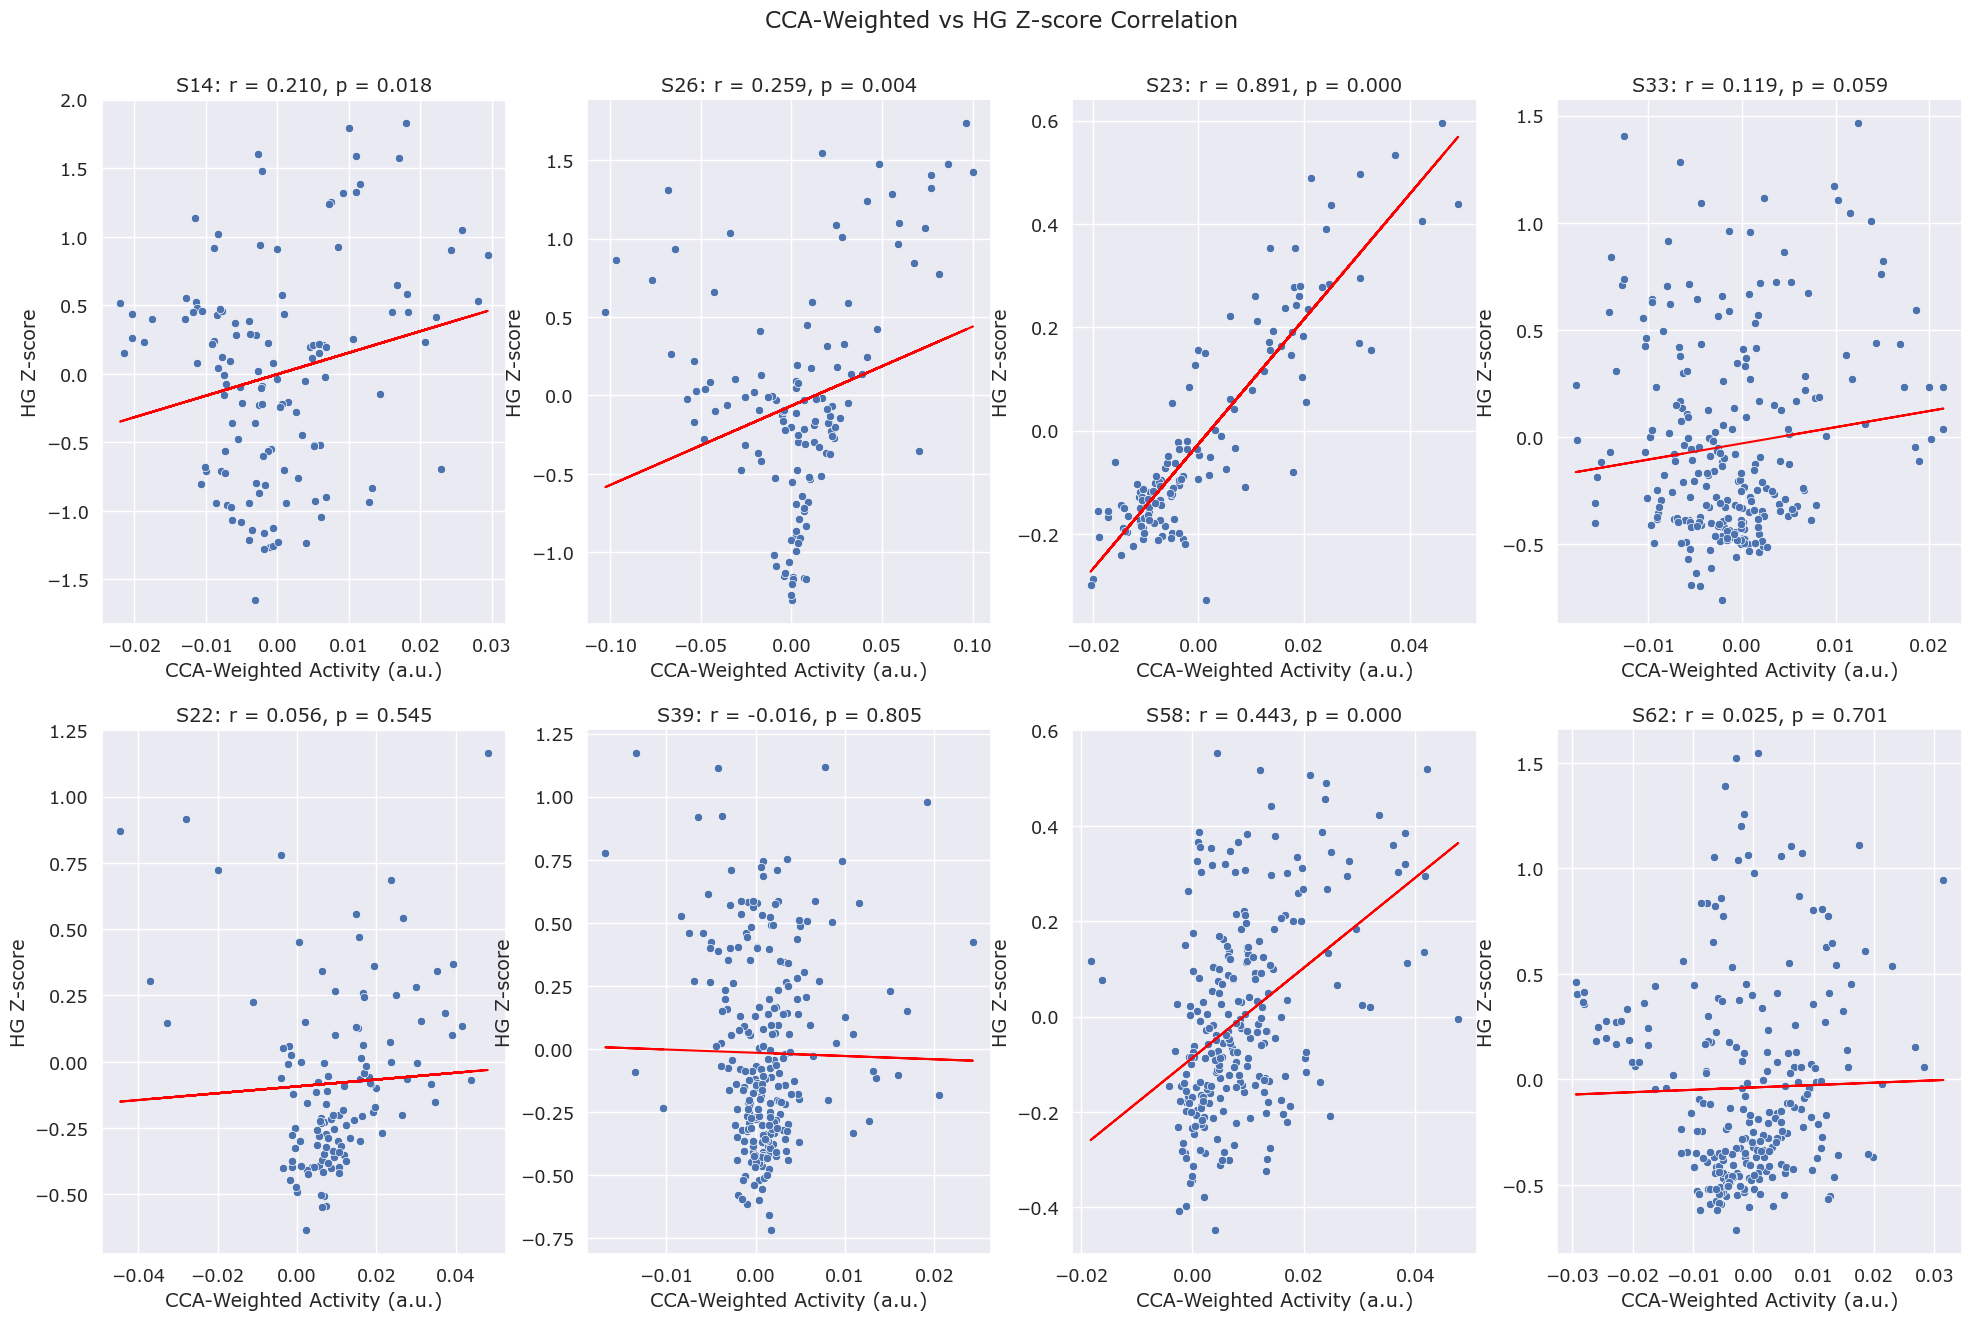

In [269]:
from scipy.stats import linregress

f, axs = plt.subplots(2, int(len(pt_names)/2), figsize=(6*len(pt_names)/2, 15))
axs = axs.flatten()
for i, pt in enumerate(pt_names):
    # calculate relationship between MCCA-Weighted and Regular HG Z-score
    slope, intercept, r_value, p_value, std_err = linregress(cca_corr_data[i], reg_corr_data[i])
    # print(slope, intercept, r_value, p_value, std_err)
    sns.scatterplot(x=cca_corr_data[i], y=reg_corr_data[i], ax=axs[i])
    axs[i].plot(cca_corr_data[i], slope*cca_corr_data[i] + intercept, color='red')
    axs[i].set_xlabel('CCA-Weighted Activity (a.u.)')
    axs[i].set_ylabel('HG Z-score')
    axs[i].set_title(f'{pt}: r = {r_value:.3f}, p = {p_value:.3f}')
plt.suptitle('CCA-Weighted vs HG Z-score Correlation', y=0.94)
plt.show()

#### Similarity between CCA components and articulator maps

In [390]:
artic_maps = sio.loadmat('../data/articulator_maps/S33/S33_articulator_maps.mat')
low_map = artic_maps['lowMap']
high_map = artic_maps['highMap']
labial_map = artic_maps['labialMap']
dorsal_map = artic_maps['dorsalMap']
artic_maps = [low_map, high_map, labial_map, dorsal_map]

In [373]:
def cos_sim(a,b):
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

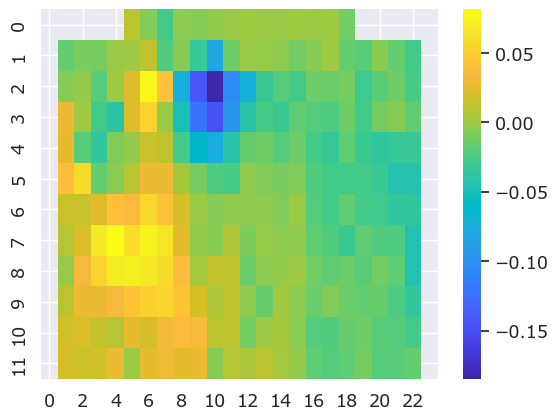

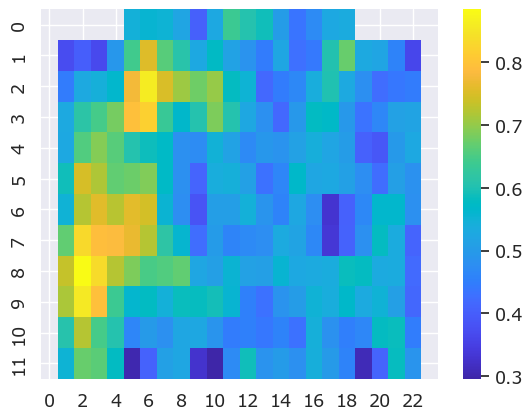

In [438]:
from sklearn.metrics.pairwise import cosine_similarity

# cca_data = cca_avg[2][~np.isnan(cca_avg[2])].reshape(len(t),-1)
# # repeat the labial map vector for all 200 timepoints
# artic_map_data = np.tile(labial_map.flatten()[:,None].T, (cca_data.shape[0],1))[~np.isnan(cca_avg[2])].reshape(len(t),-1)

# sim = np.mean(cos_sim(cca_data, artic_map_data.T), axis=1)
reg_trials = pt_cca_timeseries[pt]['Reg']
reg_mean = np.mean(reg_trials, axis=0)
reg_mean = reg_mean[~np.isnan(reg_mean)].reshape(len(t),-1)

# artic_sim_timeseries = np.zeros((len(artic_maps), len(t_ranges)))
artic_sim_timeseries_filt = np.zeros((len(artic_maps), len(t)))
artic_sim_timeseries_reg = np.zeros((len(artic_maps), len(t)))
for i, am in enumerate(artic_maps):
    flip_am = np.fliplr(am).flatten()
    speech_t_inds = np.where((t >= -0.1) & (t < 0.1))[0]
    cca_filter = cca_avg[i, speech_t_inds, :].mean(axis=0)
    cca_filter = cca_filter[~np.isnan(cca_filter)]
    # cca_filter += np.abs(np.min(cca_filter))

    # cca_data = cca_avg[i][~np.isnan(cca_avg[i])].reshape(len(t),-1)
    # cca_data += np.abs(np.min(cca_data))
    
    # for j, tr in enumerate(t_ranges):
    #     t_inds = np.where((t >= tr[0]) & (t < tr[1]))[0]
    #     cca_data = cca_avg[i, t_inds, :].mean(axis=0)
    #     cca_data = cca_data[~np.isnan(cca_data)]
    #     # cca_data = np.abs(cca_data)

    #     artic_map_data = flip_am[~np.isnan(flip_am)]

    #     sim = cos_sim(cca_data, artic_map_data)
    #     artic_sim_timeseries[i,j] = sim

    cca_data = cca_avg[i][~np.isnan(cca_avg[i])].reshape(len(t),-1)
    # cca_data += np.abs(np.min(cca_data))
    # reg_data = reg_avg[i][~np.isnan(reg_avg[i])].reshape(len(t),-1)
    # reg_filt = reg_data*cca_data
    # reg_filt = reg_data*cca_filter
    # reg_filt = reg_data
    reg_filt = reg_mean*cca_filter
    

    # cca_data = cca_avg[i][~np.isnan(cca_avg[i])].reshape(len(t),-1)

    artic_map_data = np.tile(flip_am[~np.isnan(flip_am),None].T, (reg_mean.shape[0],1)).reshape(len(t),-1)
    # sim_filt = cosine_similarity(reg_filt, artic_map_data)
    # sim_reg = cosine_similarity(reg_mean, artic_map_data)
    # sim = cosine_similarity(cca_filter[None,:], flip_am[~np.isnan(flip_am),None].T)
    sim_filt = cosine_similarity(cca_data, artic_map_data)

    # sim = cosine_similarity(reg_filt, artic_map_data)
    artic_sim_timeseries_filt[i] = np.mean(np.abs(sim_filt), axis=1)
    # artic_sim_timeseries_reg[i] = np.mean(np.abs(sim_reg), axis=1)

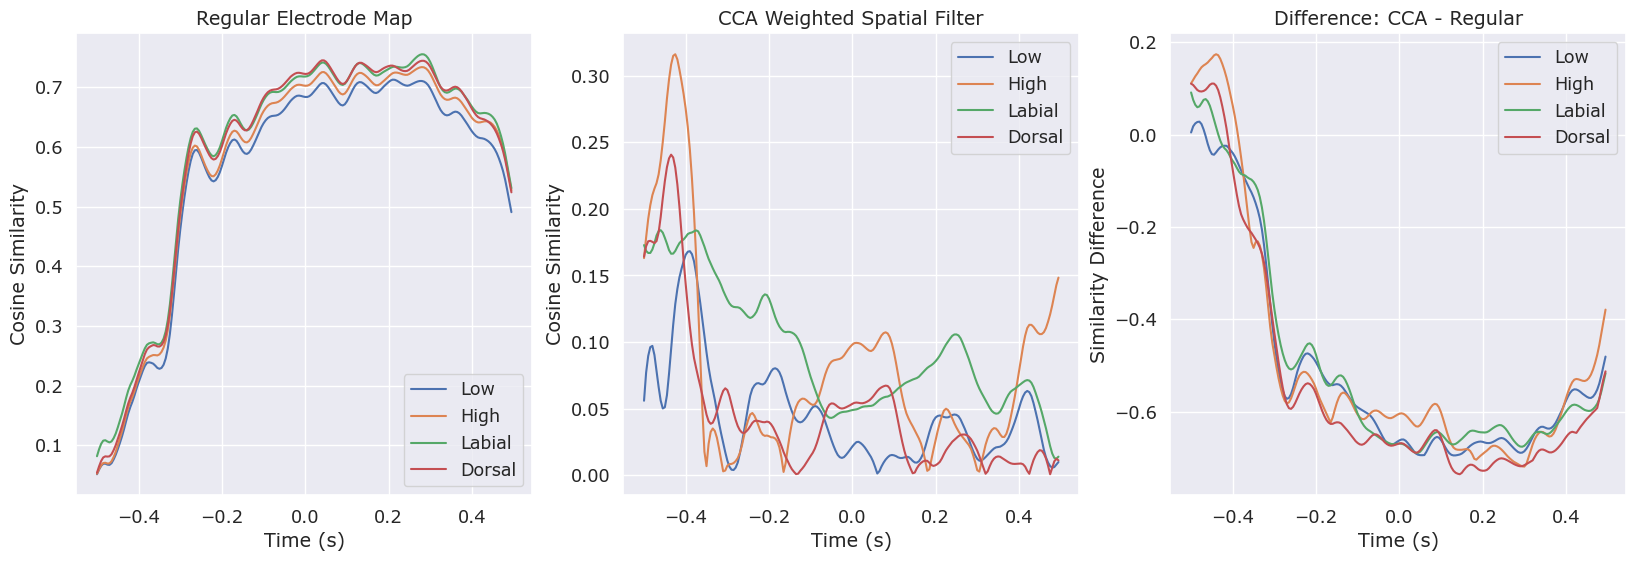

In [419]:
# f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,6))

# ax1.plot(t, artic_sim_timeseries_reg.T)
# ax1.set_xlabel('Time (s)')
# ax1.set_ylabel('Cosine Similarity')
# ax1.legend(['Low', 'High', 'Labial', 'Dorsal'])
# ax1.set_title('Regular Electrode Map')

# ax2.plot(t, artic_sim_timeseries_filt.T)
# ax2.set_xlabel('Time (s)')
# ax2.set_ylabel('Cosine Similarity')
# ax2.legend(['Low', 'High', 'Labial', 'Dorsal'])
# ax2.set_title('CCA Weighted Spatial Filter')

# ax3.plot(t, artic_sim_timeseries_filt.T - artic_sim_timeseries_reg.T)
# ax3.set_xlabel('Time (s)')
# ax3.set_ylabel('Similarity Difference')
# ax3.legend(['Low', 'High', 'Labial', 'Dorsal'])
# ax3.set_title('Difference: CCA - Regular')

# plt.show()


plt.figure()
plt.plot(t, artic_sim_timeseries_filt.T)
# plt.plot(np.mean(t_ranges, axis=1), artic_sim_timeseries.T, '-o')
plt.xlabel('Time (s)')
plt.ylabel('Cosine Similarity')
plt.legend(['Low', 'High', 'Labial', 'Dorsal'])
plt.title('CCA-Weighted Articulator Map Similarity')
plt.show()

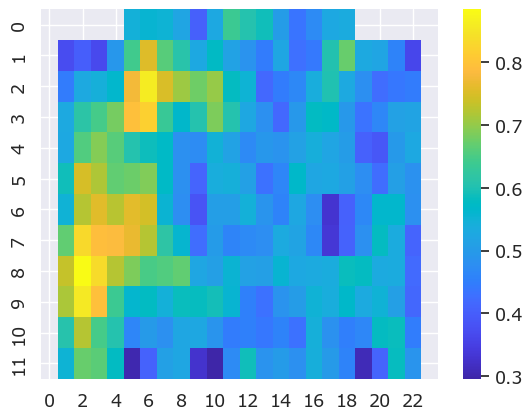

In [119]:
sns.heatmap(np.fliplr(artic_maps[3]), cmap=parula_map)
plt.show()

In [519]:
test_dict = utils.load_pkl(data_filename)

## PCA Channel Permutation Analysis

In [17]:
from sklearn.decomposition import PCA

from alignment.AlignCCA import CCA_align, extract_latent_dynamics_by_class

In [23]:
n_comp_pca = 0.9
n_comp_cca = 10
n_repeats = 100
n_comp_corr = 3

In [24]:
S14_data, S14_labels = all_pt_traces['S14'], all_pt_phon_seqs_str['S14']
S26_data, S26_labels = all_pt_traces['S26'], all_pt_phon_seqs_str['S26']

In [39]:
PCA_S14 = PCA(n_components=n_comp_pca)
PCA_S26 = PCA(n_components=n_comp_pca)

S14_data_cnd_avg = utils.cnd_avg(S14_data, S14_labels)
S26_data_cnd_avg = utils.cnd_avg(S26_data, S26_labels)

# decmopose channels (trial*time, channels)
# S14_2d = S14_data_cnd_avg.reshape(-1, S14_data.shape[-1])
# S26_2d = S26_data_cnd_avg.reshape(-1, S26_data.shape[-1])

# decompose time (trial*channel, time)
S14_2d = S14_data_cnd_avg.transpose(0,2,1).reshape(-1, S14_data.shape[1])
S26_2d = S26_data_cnd_avg.transpose(0,2,1).reshape(-1, S26_data.shape[1])

latDyn_S14 = PCA_S14.fit_transform(S14_2d)
latDyn_S26 = PCA_S26.fit_transform(S26_2d)

S14_decomp_matrix = PCA_S14.components_

In [40]:
_,_,CCs_S14_S26 = CCA_align(latDyn_S14.T, latDyn_S26.T)
CCs_S14_S26 = CCs_S14_S26[:n_comp_cca]
corr_S14_S26 = np.mean(CCs_S14_S26[:n_comp_corr])

Permute decomposition vectors

In [42]:
null_corrs = []
for i in range(n_repeats):
    S14_decomp_perm = np.zeros(S14_decomp_matrix.shape)
    for i in range(S14_decomp_matrix.shape[0]):
        perm_inds = np.random.permutation(S14_decomp_matrix.shape[1])
        S14_decomp_perm[i] = S14_decomp_matrix[i, perm_inds]
    
    # latDyn_S14_perm = np.dot(S14_data_cnd_avg.reshape(-1, S14_data.shape[-1]), S14_decomp_perm.T)
    latDyn_S14_perm = np.dot(S14_data_cnd_avg.transpose(0,2,1).reshape(-1, S14_data.shape[1]), S14_decomp_perm.T)    
        
    _,_,CCs_S14_S26_perm = CCA_align(latDyn_S14_perm.T, latDyn_S26.T)
    CCs_S14_S26_perm = CCs_S14_S26_perm[:n_comp_cca]
    
    avg_corrs = np.mean(CCs_S14_S26_perm[:n_comp_corr])
    null_corrs.append(avg_corrs)
    

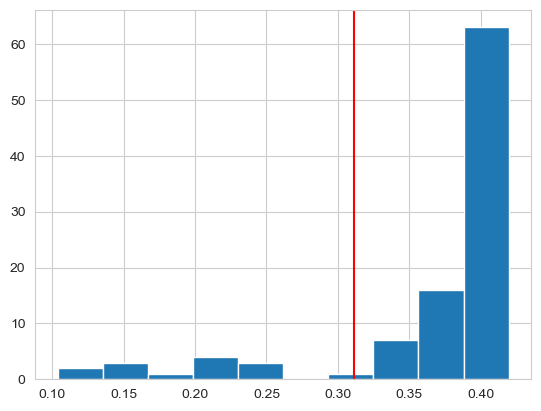

In [43]:
plt.figure()
plt.hist(null_corrs)
plt.axvline(corr_S14_S26, color='r')
plt.show()

In [44]:
from scipy.stats import ttest_1samp

res = ttest_1samp(null_corrs, corr_S14_S26, alternative='less')
print(res)

TtestResult(statistic=7.207273493240934, pvalue=0.99999999994269, df=99)


In [45]:
res.pvalue

0.99999999994269